### 0. Main task. Introduction.

### 1. Data load. 

### 2. Feature analysis
- 2.1. Numerical feature analysis.
- 2.2. Dependence of numerical features.
- 2.3. Correlation of numeric features with a target variable.

### 3. Feature handling.¶

- 3.1. Encoding categorical features.
- 3.2. Merge numerical and categorical features.
- 3.3. Train/Val/Test split.

### 4. XGBoost-model.

- 4.1. Grid Search.
- 4.2. XGBoost on optimal parameters.
- 4.3. ТOP-features with XGBoost.
- 4.4. Test different treshold.
- 4.5. Choose treshold = 0.01.

### 5. Dimensionality Reduction and Clustering.

### 6. Retrain the model on the entire dataset.

### 7. Save model.

### 0. Main task. Introduction.

In [1]:
# Load libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
import time
import os
import datetime
import pyodbc
import pickle
import matplotlib.patches as mpatches
import warnings #+

from tqdm import tqdm_notebook
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder, normalize
from sklearn.model_selection import train_test_split, GridSearchCV
from category_encoders import *

%pylab inline
warnings.filterwarnings('ignore')

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


### 1. Data load.

In [2]:
# Connectors to DataBase
conn = pyodbc.connect (
            'DRIVER={ODBC Driver 17 for SQL Server};'
            'SERVER=KI-ST-REPORTS;'
            'DATABASE=DataMart;'
            'Trusted_Connection=Yes;'
                        )

In [3]:
%%time
# Load Data Statistic
data_base_1 = pd.read_sql_query('''
     
        SELECT [UserID] AS Client_ID
      ,[UserLevelLastLoan]
      ,[UserLevelPreviousLoan]
      ,[TotalAmountLastLoan]
      ,[InterestRate_yearLastLoan]
      ,[LoanTypeLastLoan]
      ,[InterestDiscountLastLoan]
      ,[pdLastLoan]
      ,[ApiProviderIdLastLoan]
      ,[TopUpAmountLastLoan]
      ,[TopUpCountLastLoan]
      ,[TotalAmountFirstLoan]
      ,[TopUpAmountFirstLoan]
      ,[PlanLoanTermFirstLoan]
      ,[FactLoanTermFirstLoan]
      ,[isFriendReferral]
      ,[closedLoansCount]
      ,[TotalLoansCount]
      ,[TotalLoanPlanTerm]
      ,[TotalLoanFactualTerm]
      ,[LoginsCountLast1M]
      ,[LoginsCountLLast3M]
      ,[LoginsCountLast6M]
      ,[LoginsCountLast12M]
      ,[CntLoginsAfterLastLoanClosed]
      ,[avgCheck3MTillLastLoan]
      ,[avgCheck6MTillLastLoan]
      ,[avgCheck12MTillLastLoan]
      ,[loansCount3MTillLastLoan]
      ,[loansCount6MTillLastLoan]
      ,[loansCount12MTillLastLoan]
      ,[DaysBetweenPreviousLoanIssuedAndLastLoanIssued]
      ,[DaysBetweenPreviousLoanCreatedAndLastLoanCreated]
      ,[DaysInArrearsTotal]
      ,[DaysInProlongationTotal]
      ,[DaysInArrearsLastLoan]
      ,[DaysInProlongationsLastLoan]
      ,[LTV]
      ,[minInterestDiscount3MTillLastLoan]
      ,[minInterestDiscount6MTillLastLoan]
      ,[minInterestDiscount12MTillLastLoan]
      ,[maxInterestDiscount3MTillLastLoan]
      ,[maxInterestDiscount6MTillLastLoan]
      ,[maxInterestDiscount12MTillLastLoan]
      ,[avgInterestDiscount3MTillLastLoan]
      ,[avgInterestDiscount6MTillLastLoan]
      ,[avgInterestDiscount12MTillLastLoan]
  FROM [DataMart].[dbo].[temp_churnscore]     
                                ''', conn )
print ("Shape of data table", data_base_1.shape)

data_base_1.head()

Shape of data table (567566, 47)
CPU times: total: 22 s
Wall time: 22.3 s


Client_ID  UserLevelLastLoan  UserLevelPreviousLoan  TotalAmountLastLoan  \
0    2074437                3.0                    2.0              13100.0   
1    2445185                1.0                    0.0               2000.0   
2    2255440                0.0                    NaN               7000.0   
3    1805072                0.0                    NaN               6000.0   
4    2580693                0.0                    NaN                200.0   

   InterestRate_yearLastLoan  LoanTypeLastLoan  InterestDiscountLastLoan  \
0                     138.93               1.0                 70.000000   
1                     212.33               1.0                 65.000000   
2                       3.66               1.0                 70.588242   
3                       3.65               1.0                 70.588242   
4                       3.65               1.0                 99.411751   

   pdLastLoan  ApiProviderIdLastLoan  TopUpAmountLastLoan  ...       LTV  \
0   22.096596                    2.0                  0.0  ...  1.880486   
1   49.440117                    2.0                  0.0  ...  0.558278   
2   36.096573                    2.0                  0.0  ...  0.004997   
3   49.879913                    2.0                  0.0  ...  3.365544   
4    0.573635                    2.0                  0.0  ...  0.995124   

   minInterestDiscount3MTillLastLoan  minInterestDiscount6MTillLastLoan  \
0                          70.000000                          70.000000   
1                          65.000000                          65.000000   
2                          70.588242                          70.588242   
3                          70.588242                          70.588242   
4                          99.411751                          99.411751   

   minInterestDiscount12MTillLastLoan  maxInterestDiscount3MTillLastLoan  \
0                           70.000000                          70.000000   
1                           65.000000                          99.411751   
2                           70.588242                          70.588242   
3                           70.588242                          70.588242   
4                           99.411751                          99.411751   

   maxInterestDiscount6MTillLastLoan  maxInterestDiscount12MTillLastLoan  \
0                          70.000000                           70.588242   
1                          99.411751                           99.411751   
2                          70.588242                           70.588242   
3                          70.588242                           70.588242   
4                          99.411751                           99.411751   

   avgInterestDiscount3MTillLastLoan  avgInterestDiscount6MTillLastLoan  \
0                          70.000000                          70.000000   
1                          82.205875                          82.205875   
2                          70.588242                          70.588242   
3                          70.588242                          70.588242   
4                          99.411751                          99.411751   

   avgInterestDiscount12MTillLastLoan  
0                           70.294121  
1                           82.205875  
2                           70.588242  
3                           70.588242  
4                           99.411751  

[5 rows x 47 columns]

In [4]:
%%time
# Load additional Table
data_base_2 = pd.read_sql_query('''
     
             /****** Script for SelectTopNRows command from SSMS  ******/
SELECT [UserID] AS Client_ID
      ,[PromoCodesCount001FromLastLoan]
      ,[TotalCountIsReturnedfromChurnWith_0.01PromoCode]
      ,[TotalCountIsReturnedfromChurnWith_No0.01PromoCode]
      ,[TotalCountIsReturnedfromChurnWith_No0PromoCode]
      ,[avgDIC]
      ,[maxDIC]
      ,[medDIC]
      ,[minDIC]
      ,[sumDIC]
      ,[RespondShare3M_001]
      ,[RespondShare6M_001]
      ,[RespondShare12M_001]
      ,[RespondShare18M_001]
      ,[RespondShare24M_001]
      ,[RespondShare3M_NO_001]
      ,[RespondShare6M_NO_001]
      ,[RespondShare12M_NO_001]
      ,[RespondShare18M_NO_001]
      ,[RespondShare24M_NO_001]
  FROM [DataMart].[dbo].[temp_churnscore2]
                                ''', conn )
print ("Shape of data table", data_base_2.shape)

data_base_2.head()

Shape of data table (526970, 20)
CPU times: total: 4.78 s
Wall time: 4.89 s


Client_ID  PromoCodesCount001FromLastLoan  \
0    1089142                               0   
1    1286849                               0   
2    2083833                              28   
3     248837                               0   
4    2229598                               0   

   TotalCountIsReturnedfromChurnWith_0.01PromoCode  \
0                                                0   
1                                                0   
2                                                0   
3                                                0   
4                                                0   

   TotalCountIsReturnedfromChurnWith_No0.01PromoCode  \
0                                                  0   
1                                                  0   
2                                                  0   
3                                                  0   
4                                                  0   

   TotalCountIsReturnedfromChurnWith_No0PromoCode  avgDIC  maxDIC  medDIC  \
0                                               0     NaN     NaN     NaN   
1                                               1    55.0    55.0    55.0   
2                                               0     NaN     NaN     NaN   
3                                               0     NaN     NaN     NaN   
4                                               0     NaN     NaN     NaN   

   minDIC  sumDIC  RespondShare3M_001  RespondShare6M_001  \
0     NaN     NaN                 NaN                 NaN   
1    55.0    55.0                 NaN                 NaN   
2     NaN     NaN                 NaN                 NaN   
3     NaN     NaN                 NaN                 NaN   
4     NaN     NaN                 NaN                 NaN   

   RespondShare12M_001  RespondShare18M_001  RespondShare24M_001  \
0                  NaN                  NaN                  NaN   
1                  NaN                  NaN                  NaN   
2                  NaN                  NaN                  NaN   
3                  NaN                  NaN                  NaN   
4                  NaN                  NaN                  NaN   

   RespondShare3M_NO_001  RespondShare6M_NO_001  RespondShare12M_NO_001  \
0               0.000000               0.000000                0.000000   
1               0.142857               0.142857                0.142857   
2                    NaN                    NaN                     NaN   
3               0.000000               0.000000                0.000000   
4                    NaN                    NaN                     NaN   

   RespondShare18M_NO_001  RespondShare24M_NO_001  
0                0.000000                0.000000  
1                0.142857                0.142857  
2                     NaN                     NaN  
3                0.000000                0.000000  
4                     NaN                     NaN

In [5]:
%%time
# Load additional Table
data_base_3 = pd.read_sql_query('''
     
SELECT 
       [ClosedLoansCount]
      ,[ClientFirstTranDate]
      ,[ClientLastTranDate]
      ,[BirthDate]
      ,[Gender]
      ,[Region]
      ,[HouseType]
      ,[EmploymentIncome]
      ,[Spendings]
      ,[MaritalStatus]
      ,[DependentsCount]
      ,[Education]
      ,[EmploymentStatus]
      ,[EmploymentIndustry]
      ,[Client_ID]
FROM [DataMart].[dbo].[Clients]
     
                                ''', conn )
print ("Shape of data table", data_base_3.shape)

data_base_3.head()

Shape of data table (1205844, 15)
CPU times: total: 13.2 s
Wall time: 29.3 s


ClosedLoansCount ClientFirstTranDate      ClientLastTranDate   BirthDate  \
0                27 2013-11-18 20:36:29 2021-06-22 11:45:18.000  1990-08-08   
1                 1 2013-11-18 21:02:22 2013-11-18 21:02:22.000  1984-01-26   
2               306 2013-11-18 00:00:00 2021-05-31 11:45:16.000  1971-08-08   
3                30 2015-09-04 00:39:04 2021-10-30 14:45:35.790  1980-05-19   
4                11 2014-03-28 10:54:36 2017-06-01 00:17:38.000  1988-06-28   

   Gender          Region                            HouseType  \
0       1  Kyivska oblast  Володію кімнатою/квартирою/будинком   
1       1  Kyivska oblast  Володію кімнатою/квартирою/будинком   
2       1  Kyivska oblast  Володію кімнатою/квартирою/будинком   
3       1            Kiev                  Проживаю з родичами   
4       1  Kyivska oblast  Володію кімнатою/квартирою/будинком   

   EmploymentIncome  Spendings          MaritalStatus  DependentsCount  \
0             50000    30000.0      Перебуваю у шлюбі                0   
1             10000     5000.0      Перебуваю у шлюбі                0   
2              2300        1.0      Перебуваю у шлюбі                2   
3             55555    44444.0  Незаміжня/неодружений                1   
4               300      200.0      Перебуваю у шлюбі                1   

    Education  EmploymentStatus                   EmploymentIndustry  \
0        Вища  Повна зайнятість  Інформаційні технології/комунікації   
1        Вища  Повна зайнятість  Інформаційні технології/комунікації   
2        Вища  Повна зайнятість  Інформаційні технології/комунікації   
3        Вища  Повна зайнятість  Інформаційні технології/комунікації   
4  Друга вища           Студент                                 None   

   Client_ID  
0          1  
1          2  
2          3  
3          4  
4          5

In [6]:
# Merge tables
data_base = pd.merge(data_base_1, data_base_2, how = 'left', on = ['Client_ID'])
data_base = pd.merge(data_base, data_base_3, how = 'left', on = ['Client_ID'])

del data_base_3, data_base_2, data_base_1

print ("Shape Data table", data_base.shape)
data_base

Shape Data table (567566, 80)


Client_ID  UserLevelLastLoan  UserLevelPreviousLoan  \
0         2074437                3.0                    2.0   
1         2445185                1.0                    0.0   
2         2255440                0.0                    NaN   
3         1805072                0.0                    NaN   
4         2580693                0.0                    NaN   
...           ...                ...                    ...   
567561    2624812                0.0                    0.0   
567562    1707700                1.0                    1.0   
567563    2103652                0.0                    NaN   
567564    2139573                0.0                    0.0   
567565     510602                3.0                    2.0   

        TotalAmountLastLoan  InterestRate_yearLastLoan  LoanTypeLastLoan  \
0                   13100.0                     138.93               1.0   
1                    2000.0                     212.33               1.0   
2                    7000.0                       3.66               1.0   
3                    6000.0                       3.65               1.0   
4                     200.0                       3.65               1.0   
...                     ...                        ...               ...   
567561               2100.0                     620.50               1.0   
567562                820.0                     581.94               1.0   
567563               4000.0                       3.66               1.0   
567564               2250.0                     622.20               1.0   
567565              15000.0                     248.79               1.0   

        InterestDiscountLastLoan  pdLastLoan  ApiProviderIdLastLoan  \
0                      70.000000   22.096596                    2.0   
1                      65.000000   49.440117                    2.0   
2                      70.588242   36.096573                    2.0   
3                      70.588242   49.879913                    2.0   
4                      99.411751    0.573635                    2.0   
...                          ...         ...                    ...   
567561                       NaN    1.025853                    2.0   
567562                       NaN    2.415930                    2.0   
567563                 70.588242   20.478373                    2.0   
567564                       NaN   53.278805                    2.0   
567565                 50.000000   44.984844                    2.0   

        TopUpAmountLastLoan  ...  Gender          Region  \
0                       0.0  ...       1      Kirovograd   
1                       0.0  ...       1        Zhitomir   
2                       0.0  ...       1  Kyivska oblast   
3                       0.0  ...       2  Kyivska oblast   
4                       0.0  ...       1      Zaporozhye   
...                     ...  ...     ...             ...   
567561                  0.0  ...       2           Lutsk   
567562                320.0  ...       1      Zaporozhye   
567563                  0.0  ...       1         Donetsk   
567564                  0.0  ...       2  IvanoFrankovsk   
567565                  0.0  ...       2  Kyivska oblast   

                                           HouseType  EmploymentIncome  \
0                Володію кімнатою/квартирою/будинком             20000   
1                                Проживаю з родичами             10000   
2                                Проживаю з родичами             15000   
3       Частково володію кімнатою/квартирою/будинком             15000   
4                                Проживаю з родичами              1500   
...                                              ...               ...   
567561                           Проживаю з родичами              1100   
567562                           Проживаю з родичами              5000   
567563                           Проживаю з родичами              8500   
567564                  

In [11]:
# Create additional features
data_base = data_base[~data_base.ClientFirstTranDate.isna()]
###############################     Clients Age   ##################################  

data_base['Age'] = ((pd.Timestamp('now') - 
  pd.to_datetime(data_base['BirthDate'], format="%Y-%m-%d")).dt.days/365.25).astype(int)

###############################     Days with MV   ##################################  

data_base['days_with_MV'] = (( pd.to_datetime(data_base['ClientLastTranDate'], format="%Y-%m-%d") - 
  pd.to_datetime(data_base['ClientFirstTranDate'], format="%Y-%m-%d")).dt.days).astype(int)


print ("Shape Data table", data_base.shape)
data_base

Shape Data table (567565, 82)


Client_ID  UserLevelLastLoan  UserLevelPreviousLoan  \
0         2074437                3.0                    2.0   
1         2445185                1.0                    0.0   
2         2255440                0.0                    NaN   
3         1805072                0.0                    NaN   
4         2580693                0.0                    NaN   
...           ...                ...                    ...   
567561    2624812                0.0                    0.0   
567562    1707700                1.0                    1.0   
567563    2103652                0.0                    NaN   
567564    2139573                0.0                    0.0   
567565     510602                3.0                    2.0   

        TotalAmountLastLoan  InterestRate_yearLastLoan  LoanTypeLastLoan  \
0                   13100.0                     138.93               1.0   
1                    2000.0                     212.33               1.0   
2                    7000.0                       3.66               1.0   
3                    6000.0                       3.65               1.0   
4                     200.0                       3.65               1.0   
...                     ...                        ...               ...   
567561               2100.0                     620.50               1.0   
567562                820.0                     581.94               1.0   
567563               4000.0                       3.66               1.0   
567564               2250.0                     622.20               1.0   
567565              15000.0                     248.79               1.0   

        InterestDiscountLastLoan  pdLastLoan  ApiProviderIdLastLoan  \
0                      70.000000   22.096596                    2.0   
1                      65.000000   49.440117                    2.0   
2                      70.588242   36.096573                    2.0   
3                      70.588242   49.879913                    2.0   
4                      99.411751    0.573635                    2.0   
...                          ...         ...                    ...   
567561                       NaN    1.025853                    2.0   
567562                       NaN    2.415930                    2.0   
567563                 70.588242   20.478373                    2.0   
567564                       NaN   53.278805                    2.0   
567565                 50.000000   44.984844                    2.0   

        TopUpAmountLastLoan  ...  \
0                       0.0  ...   
1                       0.0  ...   
2                       0.0  ...   
3                       0.0  ...   
4                       0.0  ...   
...                     ...  ...   
567561                  0.0  ...   
567562                320.0  ...   
567563                  0.0  ...   
567564                  0.0  ...   
567565                  0.0  ...   

                                           HouseType  EmploymentIncome  \
0                Володію кімнатою/квартирою/будинком             20000   
1                                Проживаю з родичами             10000   
2                                Проживаю з родичами             15000   
3       Частково володію кімнатою/квартирою/будинком             15000   
4                                Проживаю з родичами              1500   
...                                              ...               ...   
567561                           Проживаю з родичами              1100   
567562                           Проживаю з родичами              5000   
567563                           Проживаю з родичами              8500   
567564                           Проживаю з родичами              7000   
567565                           Проживаю з родичами             15000   

        Spendings          MaritalStatus  DependentsCount           Education  \
0          6000.0      Перебуваю у шлюбі                2  Середня спеціальна   
1

In [12]:
# Проаналізуємо інформативність ознак
data_base.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 567565 entries, 0 to 567565
Data columns (total 82 columns):
 #   Column                                             Non-Null Count   Dtype         
---  ------                                             --------------   -----         
 0   Client_ID                                          567565 non-null  int64         
 1   UserLevelLastLoan                                  567553 non-null  float64       
 2   UserLevelPreviousLoan                              335370 non-null  float64       
 3   TotalAmountLastLoan                                567551 non-null  float64       
 4   InterestRate_yearLastLoan                          567553 non-null  float64       
 5   LoanTypeLastLoan                                   567553 non-null  float64       
 6   InterestDiscountLastLoan                           353843 non-null  float64       
 7   pdLastLoan                                         567531 non-null  float64       
 8   ApiP

In [14]:
data_base.drop(['ClientFirstTranDate', 'ClientLastTranDate', 'BirthDate'], axis = 1, inplace = True)

print ("Shape of data table", data_base.shape)
data_base

Shape of data table (567565, 79)


Client_ID  UserLevelLastLoan  UserLevelPreviousLoan  \
0         2074437                3.0                    2.0   
1         2445185                1.0                    0.0   
2         2255440                0.0                    NaN   
3         1805072                0.0                    NaN   
4         2580693                0.0                    NaN   
...           ...                ...                    ...   
567561    2624812                0.0                    0.0   
567562    1707700                1.0                    1.0   
567563    2103652                0.0                    NaN   
567564    2139573                0.0                    0.0   
567565     510602                3.0                    2.0   

        TotalAmountLastLoan  InterestRate_yearLastLoan  LoanTypeLastLoan  \
0                   13100.0                     138.93               1.0   
1                    2000.0                     212.33               1.0   
2                    7000.0                       3.66               1.0   
3                    6000.0                       3.65               1.0   
4                     200.0                       3.65               1.0   
...                     ...                        ...               ...   
567561               2100.0                     620.50               1.0   
567562                820.0                     581.94               1.0   
567563               4000.0                       3.66               1.0   
567564               2250.0                     622.20               1.0   
567565              15000.0                     248.79               1.0   

        InterestDiscountLastLoan  pdLastLoan  ApiProviderIdLastLoan  \
0                      70.000000   22.096596                    2.0   
1                      65.000000   49.440117                    2.0   
2                      70.588242   36.096573                    2.0   
3                      70.588242   49.879913                    2.0   
4                      99.411751    0.573635                    2.0   
...                          ...         ...                    ...   
567561                       NaN    1.025853                    2.0   
567562                       NaN    2.415930                    2.0   
567563                 70.588242   20.478373                    2.0   
567564                       NaN   53.278805                    2.0   
567565                 50.000000   44.984844                    2.0   

        TopUpAmountLastLoan  ...  \
0                       0.0  ...   
1                       0.0  ...   
2                       0.0  ...   
3                       0.0  ...   
4                       0.0  ...   
...                     ...  ...   
567561                  0.0  ...   
567562                320.0  ...   
567563                  0.0  ...   
567564                  0.0  ...   
567565                  0.0  ...   

                                           HouseType  EmploymentIncome  \
0                Володію кімнатою/квартирою/будинком             20000   
1                                Проживаю з родичами             10000   
2                                Проживаю з родичами             15000   
3       Частково володію кімнатою/квартирою/будинком             15000   
4                                Проживаю з родичами              1500   
...                                              ...               ...   
567561                           Проживаю з родичами              1100   
567562                           Проживаю з родичами              5000   
567563                           Проживаю з родичами              8500   
567564                           Проживаю з родичами              7000   
567565                           Проживаю з родичами             15000   

        Spendings          MaritalStatus  DependentsCount           Education  \
0          6000.0      Перебуваю у шлюбі                2  Середня спеціальна   
1

In [16]:
# Split features
num_features = list(data_base._get_numeric_data().columns)
cat_features = list(set(data_base.columns) - set(num_features))

print('***************************************')
print('Numerical features =', num_features)
print('***************************************')
print('Categorical features =', cat_features)

***************************************
Numerical features = ['Client_ID', 'UserLevelLastLoan', 'UserLevelPreviousLoan', 'TotalAmountLastLoan', 'InterestRate_yearLastLoan', 'LoanTypeLastLoan', 'InterestDiscountLastLoan', 'pdLastLoan', 'ApiProviderIdLastLoan', 'TopUpAmountLastLoan', 'TopUpCountLastLoan', 'TotalAmountFirstLoan', 'TopUpAmountFirstLoan', 'PlanLoanTermFirstLoan', 'FactLoanTermFirstLoan', 'isFriendReferral', 'closedLoansCount', 'TotalLoansCount', 'TotalLoanPlanTerm', 'TotalLoanFactualTerm', 'LoginsCountLast1M', 'LoginsCountLLast3M', 'LoginsCountLast6M', 'LoginsCountLast12M', 'CntLoginsAfterLastLoanClosed', 'avgCheck3MTillLastLoan', 'avgCheck6MTillLastLoan', 'avgCheck12MTillLastLoan', 'loansCount3MTillLastLoan', 'loansCount6MTillLastLoan', 'loansCount12MTillLastLoan', 'DaysBetweenPreviousLoanIssuedAndLastLoanIssued', 'DaysBetweenPreviousLoanCreatedAndLastLoanCreated', 'DaysInArrearsTotal', 'DaysInProlongationTotal', 'DaysInArrearsLastLoan', 'DaysInProlongationsLastLoan', 'LTV

In [35]:
# Total Target Statistics
print('Total Apps = ', data_base['isCreated'].sum())
print('Total Issues = ', data_base['isIssue'].sum())
print('Conversion rate from Apps to Issues = ', round((data_base['isIssue'].sum())/
      (data_base['isCreated'].sum())*100, 2))

Total Apps =  66006
Total Issues =  58833
Conversion rate from Apps to Issues =  89.13


In [49]:
# Total Discount Statistics
Pivot_discount = pd.pivot_table(data = data_base, 
                               index = ["InterestDiscount"], 
                               values = ["id", 'isCreated'],  
                               aggfunc = {'id' : len,
                                         'isCreated' : sum}
                                 )
# Renaim columns
Pivot_discount.columns = ['Total_sms', 'Total_Apps']

# Add conversion for data
Pivot_discount['Conversion, %'] = Pivot_discount['Total_Apps'] / Pivot_discount['Total_sms'] * 100

pd.set_option('display.max_rows', 70)
Pivot_discount

Total_sms  Total_Apps  Conversion, %
InterestDiscount                                      
50.0                 127054        2849       2.242354
55.0                 136738        3976       2.907751
60.0                 290913        7191       2.471873
61.0                   4321          66       1.527424
65.0                  46150        1186       2.569881
69.0                   8879         115       1.295191
70.0                 567286       15438       2.721379
73.0                  17145         160       0.933217
75.0                 417733       16823       4.027214
77.0                  14063         117       0.831970
79.0                   4375          23       0.525714
80.0                 256118       14212       5.549005
85.0                  26363        2567       9.737132
87.0                   6404         114       1.780137

In [37]:
# Delete Veocard, mess and Promo with -99.9% for Churn from database
print('Total delete Rows = ', len(data_base[data_base['Name'].str.contains('Veocard')]) + 
     len(data_base[data_base['Name'].str.contains('не отправлять')]) +
     len(data_base[data_base['InterestDiscount'] >= 90]) + 
     len(data_base[data_base['InterestDiscount'] != 30]))

# Delete from Base Promo with -99.9% for Churn
data_base = data_base[data_base['InterestDiscount'] < 90]
data_base = data_base[data_base['InterestDiscount'] != 30]
data_base = data_base[~data_base['Name'].str.contains('Veocard')]
data_base = data_base[~data_base['Name'].str.contains('не отправлять')]

print ("Shape of data table", data_base.shape)

data_base

Total delete Rows =  2659706
Shape of data table (1923542, 77)


id   UserId PromoCodeCreated  PromoCompanyId  \
0        95675774  2311366       2021-12-30            9283   
1        92490166  2312634       2021-12-06            9063   
2        92513701  2311366       2021-12-06            9066   
3        93678995  2303061       2021-12-17            9147   
5        92246525  2308907       2021-12-01            9050   
...           ...      ...              ...             ...   
2349806  94723881  2892097       2021-12-25            9227   
2349807  94868213  2904852       2021-12-28            9237   
2349808  94329186  2904852       2021-12-24            9207   
2349809  93685607  2903647       2021-12-17            9150   
2349810  95213917  2910149       2021-12-29            9250   

                                          Name Promo_Type  isIssue  isCreated  \
0           Рассылка PDL -80% 30.12 sms close2   Campaign        0          0   
1         Рассылка PDL -60% 06.12 viber close2   Campaign        0          0   
2           Рассылка PDL -60% 06.12 sms close2   Campaign        0          0   
3        Рассылка PDL -85% 17.12 Predchurn sms   Campaign        0          0   
5           Рассылка PDL -50% 01.12 sms close2   Campaign        0          0   
...                                        ...        ...      ...        ...   
2349806     Рассылка PDL -80% 25.12 sms close1   Campaign        0          0   
2349807     Рассылка PDL -70% 28.12 sms close1   Campaign        0          0   
2349808     Рассылка PDL -75% 24.12 sms close1   Campaign        0          0   
2349809     Рассылка PDL -80% 17.12 sms close1   Campaign        0          0   
2349810     Рассылка PDL -70% 29.12 sms close1   Campaign        0          0   

         InterestDiscount  StartDate  ... RespondShare1M  RespondShare3M  \
0                    80.0 2021-12-28  ...            0.0        0.000000   
1                    60.0 2021-12-06  ...            0.1        0.045455   
2                    60.0 2021-12-06  ...            0.0        0.000000   
3                    85.0 2021-12-17  ...            0.0        0.000000   
5                    50.0 2021-12-01  ...            0.0        0.000000   
...                   ...        ...  ...            ...             ...   
2349806              80.0 2021-12-25  ...            0.0        0.000000   
2349807              70.0 2021-12-28  ...            0.0        0.000000   
2349808              75.0 2021-12-24  ...            0.0        0.000000   
2349809              80.0 2021-12-17  ...            0.0        0.000000   
2349810              70.0 2021-12-29  ...            0.0        0.000000   

         RespondShare6M  CntLoginsAfterLoanClosed  \
0              0.000000                         7   
1              0.033333                         4   
2              0.000000                         7   
3              0.000000                         1   
5              0.000000                         0   
...                 ...                       ...   
2349806        0.000000                         0   
2349807        0.000000                         0   
2349808        0.000000                         0   
2349809        0.000000                         0   
2349810        0.000000                         3   

         DaysBetweenLastLoginAndPromoCodeCreated  ShareDiscountLast3Loans  \
0                                          162.0                 0.000000   
1                                            3.0                 0.333333   
2                                          138.0                 0.000000   
3                                           25.0                 1.000000   
5                                           29.0                 1.000000   
...                                          ...                      ...   
2349806                                      NaN                 1.000000   
2349807                                      8.0                 1.000000   
2349808                                   

In [38]:
# Add new features:
data_base['InterestDiscount_5'] = ((data_base['InterestDiscount'] / 5).apply(np.floor) * 5)
data_base['InterestDiscount_10'] = ((data_base['InterestDiscount'] / 10).apply(np.floor) * 10)

print ("Shape of data table", data_base.shape)
data_base

Shape of data table (1923542, 79)


id   UserId PromoCodeCreated  PromoCompanyId  \
0        95675774  2311366       2021-12-30            9283   
1        92490166  2312634       2021-12-06            9063   
2        92513701  2311366       2021-12-06            9066   
3        93678995  2303061       2021-12-17            9147   
5        92246525  2308907       2021-12-01            9050   
...           ...      ...              ...             ...   
2349806  94723881  2892097       2021-12-25            9227   
2349807  94868213  2904852       2021-12-28            9237   
2349808  94329186  2904852       2021-12-24            9207   
2349809  93685607  2903647       2021-12-17            9150   
2349810  95213917  2910149       2021-12-29            9250   

                                          Name Promo_Type  isIssue  isCreated  \
0           Рассылка PDL -80% 30.12 sms close2   Campaign        0          0   
1         Рассылка PDL -60% 06.12 viber close2   Campaign        0          0   
2           Рассылка PDL -60% 06.12 sms close2   Campaign        0          0   
3        Рассылка PDL -85% 17.12 Predchurn sms   Campaign        0          0   
5           Рассылка PDL -50% 01.12 sms close2   Campaign        0          0   
...                                        ...        ...      ...        ...   
2349806     Рассылка PDL -80% 25.12 sms close1   Campaign        0          0   
2349807     Рассылка PDL -70% 28.12 sms close1   Campaign        0          0   
2349808     Рассылка PDL -75% 24.12 sms close1   Campaign        0          0   
2349809     Рассылка PDL -80% 17.12 sms close1   Campaign        0          0   
2349810     Рассылка PDL -70% 29.12 sms close1   Campaign        0          0   

         InterestDiscount  StartDate  ... RespondShare6M  \
0                    80.0 2021-12-28  ...       0.000000   
1                    60.0 2021-12-06  ...       0.033333   
2                    60.0 2021-12-06  ...       0.000000   
3                    85.0 2021-12-17  ...       0.000000   
5                    50.0 2021-12-01  ...       0.000000   
...                   ...        ...  ...            ...   
2349806              80.0 2021-12-25  ...       0.000000   
2349807              70.0 2021-12-28  ...       0.000000   
2349808              75.0 2021-12-24  ...       0.000000   
2349809              80.0 2021-12-17  ...       0.000000   
2349810              70.0 2021-12-29  ...       0.000000   

         CntLoginsAfterLoanClosed  DaysBetweenLastLoginAndPromoCodeCreated  \
0                               7                                    162.0   
1                               4                                      3.0   
2                               7                                    138.0   
3                               1                                     25.0   
5                               0                                     29.0   
...                           ...                                      ...   
2349806                         0                                      NaN   
2349807                         0                                      8.0   
2349808                         0                                      4.0   
2349809                         0                                      0.0   
2349810                         3                                      5.0   

         ShareDiscountLast3Loans  minInterestDiscountLast5Loan  \
0                       0.000000                           NaN   
1                       0.333333                     80.000000   
2                       0.000000                           NaN   
3                       1.000000                     99.411751   
5                       1.000000                     99.411751   
...                          ...                           ...   
2349806                 1.000000                     99.411751   
2349807                 1.000000                     99.411751   
2349808                 1.000000 

In [39]:
############################### Feature Selection ##################################

# Числові ознаки
column_numbers = ['InterestDiscount', 'StartDate_DayofWeek', 'StartDate_Day', 'Days',
       'LoginsCountLastWeek', 'LoginsCountLastMonth', 'LoginsCountLastQuater',
       'LoginsCountLast6m', 'ClosedLoansCount', 'Gender', 'PD', 'InterestRate_year', 
       'loantype', 'Age', 'Loyaltylevel', 'DependentsCount',
       'EmploymentIncome', 'Spendings', 'DaysWITHMoneyveo', 'FriendReferral',
       'DaysInArrears', 'DaysInProlongation', 'avgCheck_3month',
       'avgCheck_6month', 'avgCheck_12month', 'DaysBetweenClosedDateAndPromoCodeCreated',
       'DaysBetweenClosedPreviousCreatedLast', 'PromoCodesCount1M',
       'PromoCodesCount3M', 'PromoCodesCount6M', 'MinDiscount1M',
       'MinDiscount3M', 'MinDiscount6M', 'maxDiscount1M', 'maxDiscount3M',
       'maxDiscount6M', 'avgDiscount1M', 'avgDiscount3M', 'avgDiscount6M',
       'LoansCount1M', 'LoansCount3M', 'LoansCount6M',
       'minInterestDiscountLast3Loan', 'maxInterestDiscountLast3Loan',
       'avgInterestDiscountLast3Loan',
       'PromocodeMinusPreviousApplicationDiscount',
       'DaysBetweenPCUApplicationIssuedLastAndPCUApplicationIssuedPrevious',
       'DaysBetweenPCUApplicationCreatedLastAndPCUApplicationCreatedPrevious',
       'DaysBetweenPreviousLoanCreatedAndLastLoanCreated',
       'DaysBetweenPreviousLoanIssueddAndLastLoanIssued', 'InterestDiscount_5',
       'InterestDiscount_10', 'CntLoginsAfterLoanClosed', 'DaysBetweenLastLoginAndPromoCodeCreated',
       'RespondShare1M', 'RespondShare3M', 'RespondShare6M', 'ShareDiscountLast3Loans',
       'ShareDiscountLast5Loans', 'avgInterestDiscountLast5Loan', 
       'maxInterestDiscountLast5Loan', 'minInterestDiscountLast5Loan']
                  
# Категоріальні ознаки
column_categorical = ['PreviousStatusGroupName', 'Region', 'MaritalStatus', 'Education',
                      'EmploymentIndustry', 'EmploymentStatus',  'cpa']

############################### Labels Data ##################################
target = ['isCreated']
#target = ['isIssue']
data_target = data_base[target]

############################### Feature Data ##################################

data = data_base[column_numbers + column_categorical]
data_total = data_base[column_numbers + column_categorical + target]

print ("Shape Data Total table", data_base.shape)
print ("Shape Train/Test table", data.shape)
print ("Shape Labels table", data_target.shape)

data.head()

Shape Data Total table (1923542, 79)
Shape Train/Test table (1923542, 69)
Shape Labels table (1923542, 1)


InterestDiscount  StartDate_DayofWeek  StartDate_Day  Days  \
0              80.0                    2             28     3   
1              60.0                    1              6     5   
2              60.0                    1              6     5   
3              85.0                    5             17     3   
5              50.0                    3              1     3   

   LoginsCountLastWeek  LoginsCountLastMonth  LoginsCountLastQuater  \
0                    0                     0                      0   
1                    4                     6                     24   
2                    0                     0                      0   
3                    0                     1                      1   
5                    0                     5                      6   

   LoginsCountLast6m  ClosedLoansCount  Gender  ...  \
0                  8               7.0     1.0  ...   
1                103              41.0     2.0  ...   
2                 12               7.0     1.0  ...   
3                  6               1.0     1.0  ...   
5                  9               2.0     2.0  ...   

   avgInterestDiscountLast5Loan  maxInterestDiscountLast5Loan  \
0                           NaN                           NaN   
1                     80.000000                     80.000000   
2                           NaN                           NaN   
3                     99.411751                     99.411751   
5                     99.411751                     99.411751   

   minInterestDiscountLast5Loan  PreviousStatusGroupName      Region  \
0                           NaN                     Live       Lutsk   
1                     80.000000                     Live  Kirovograd   
2                           NaN                     Live       Lutsk   
3                     99.411751                     Live        Sumy   
5                     99.411751                  Arrears     Kherson   

           MaritalStatus           Education          EmploymentIndustry  \
0  Незаміжня/неодружений  Середня спеціальна  Будівництво та нерухомість   
1      Перебуваю у шлюбі  Середня спеціальна                    Торгівля   
2  Незаміжня/неодружений  Середня спеціальна  Будівництво та нерухомість   
3  Незаміжня/неодружений  Середня спеціальна  Будівництво та нерухомість   
5      Перебуваю у шлюбі  Середня спеціальна                    Торгівля   

     EmploymentStatus           cpa  
0  Неповна зайнятість          None  
1              Декрет      ukrleads  
2  Неповна зайнятість          None  
3    Повна зайнятість  salesdoubler  
5  Неповна зайнятість  salesdoubler  

[5 rows x 69 columns]

In [40]:
# Проаналізуємо числові ознаки
data.describe().T

count          mean  \
InterestDiscount                                    1923542.0     68.733384   
StartDate_DayofWeek                                 1923542.0      2.917896   
StartDate_Day                                       1923542.0     17.855677   
Days                                                1923542.0      2.139578   
LoginsCountLastWeek                                 1923542.0      0.702431   
LoginsCountLastMonth                                1923542.0      3.080884   
LoginsCountLastQuater                               1923542.0     10.019822   
LoginsCountLast6m                                   1923542.0     20.421097   
ClosedLoansCount                                    1923541.0     10.208512   
Gender                                              1923541.0      1.426929   
PD                                                  1921216.0     10.714826   
InterestRate_year                                   1923539.0    254.174282   
loantype                                            1923539.0      1.054618   
Age                                                 1923541.0     30.504700   
Loyaltylevel                                        1923541.0      1.077706   
DependentsCount                                     1923541.0      0.589514   
EmploymentIncome                                    1923541.0  12788.163871   
Spendings                                           1923541.0   5589.533707   
DaysWITHMoneyveo                                    1923541.0    629.325328   
FriendReferral                                      1923542.0      0.310839   
DaysInArrears                                        556448.0      2.957556   
DaysInProlongation                                   911436.0    108.073909   
avgCheck_3month                                     1136393.0   6424.711655   
avgCheck_6month                                     1645429.0   5794.973390   
avgCheck_12month                                    1863896.0   5576.961046   
DaysBetweenClosedDateAndPromoCodeCreated            1923539.0     64.341544   
DaysBetweenClosedPreviousCreatedLast                1294052.0     64.444600   
PromoCodesCount1M                                   1923542.0      5.696154   
PromoCodesCount3M                                   1923542.0     14.536154   
PromoCodesCount6M                                   1923542.0     20.588610   
MinDiscount1M                                       1832422.0     51.371247   
MinDiscount3M                                       1877428.0     39.871158   
MinDiscount6M                                       1886226.0     37.090702   
maxDiscount1M                                       1832422.0     79.081290   
maxDiscount3M                                       1877428.0     81.837749   
maxDiscount6M                                       1886226.0     82.713906   
avgDiscount1M                                       1832422.0     67.408300   
avgDiscount3M                                       1877428.0     65.030912   
avgDiscount6M                                       1886226.0     63.371778   
LoansCount1M                                        1923542.0      0.916218   
LoansCount3M                                        1923542.0      1.704175   
LoansCount6M                                        1923542.0      2.909159   
minInterestDiscountLast3Loan                        1614200.0     78.715792   
maxInterestDiscountLast3Loan                        1614200.0     87.955841   
avgInterestDiscountLast3Loan                        1614200.0     83.337602   
PromocodeMinusPreviousApplicationDiscount           1772985.0    -19.205821   
DaysBetweenPCUApplicationIssuedLastAndPCUApplic...   840597.0     97.096238   
DaysBetweenPCUApplicationCreatedLastAndPCUAppli...   957480.0      0.000000   
DaysBetweenPreviousLoanCreatedAndLastLoanCreated    1405331.0     53.104294   
DaysBetweenPreviousLoanIssueddAndLastLoanIssued     1354291.0     54.929684   
InterestDiscount_5         

In [50]:
# Перевіримо вибірку на збалансованість - вибірка не збалансована
data_target.value_counts(normalize=True, ascending = False)*100

isCreated
0            96.629291
1             3.370709
dtype: float64

In [42]:
# Проаналізуємо інформативність ознак
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1923542 entries, 0 to 2349810
Data columns (total 69 columns):
 #   Column                                                                Dtype  
---  ------                                                                -----  
 0   InterestDiscount                                                      float64
 1   StartDate_DayofWeek                                                   int64  
 2   StartDate_Day                                                         int64  
 3   Days                                                                  int64  
 4   LoginsCountLastWeek                                                   int64  
 5   LoginsCountLastMonth                                                  int64  
 6   LoginsCountLastQuater                                                 int64  
 7   LoginsCountLast6m                                                     int64  
 8   ClosedLoansCount                                    

In [15]:
# Проаналізуємо відсоток пропусків в даних
# Означимо функцію:
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns
    
missing_values_table(data_base)

Your selected dataframe has 79 columns.
There are 57 columns that have missing values.


Missing Values  \
RespondShare18M_001                                        523666   
RespondShare12M_001                                        523666   
RespondShare3M_001                                         523666   
RespondShare6M_001                                         523666   
RespondShare24M_001                                        523666   
avgDIC                                                     488940   
maxDIC                                                     488940   
medDIC                                                     488940   
minDIC                                                     488940   
sumDIC                                                     488940   
DaysInProlongationsLastLoan                                396467   
RespondShare3M_NO_001                                      306801   
RespondShare6M_NO_001                                      306801   
RespondShare12M_NO_001                                     306801   
RespondShare18M_NO_001                                     306801   
RespondShare24M_NO_001                                     306801   
DaysInProlongationTotal                                    297133   
UserLevelPreviousLoan                                      232195   
DaysBetweenPreviousLoanIssuedAndLastLoanIssued             232195   
DaysInArrearsLastLoan                                      228604   
InterestDiscountLastLoan                                   213722   
DaysInArrearsTotal                                         195336   
DaysBetweenPreviousLoanCreatedAndLastLoanCreated           150236   
EmploymentIndustry                                         118463   
maxInterestDiscount3MTillLastLoan                          101763   
avgInterestDiscount3MTillLastLoan                          101763   
minInterestDiscount3MTillLastLoan                          101763   
minInterestDiscount6MTillLastLoan                           66963   
maxInterestDiscount6MTillLastLoan                           66963   
avgInterestDiscount6MTillLastLoan                           66963   
TotalCountIsReturnedfromChurnWith_No0.01PromoCode           40596   
PromoCodesCount001FromLastLoan                              40596   
TotalCountIsReturnedfromChurnWith_0.01PromoCode             40596   
TotalCountIsReturnedfromChurnWith_No0PromoCode              40596   
minInterestDiscount12MTillLastLoan                          35089   
maxInterestDiscount12MTillLastLoan                          35089   
avgInterestDiscount12MTillLastLoan                          35089   
pdLastLoan                                                     34   
FactLoanTermFirstLoan                                          14   
TopUpCountLastLoan                                             14   
TotalAmountFirstLoan                                           14   
TopUpAmountFirstLoan                                           14   
PlanLoanTermFirstLoan                                          14   
TopUpAmountLastLoan                                            14   
avgCheck12MTillLastLoan                                        14   
TotalAmountLastLoan                                            14   
avgCheck3MTillLastLoan                                         14   
avgCheck6MTillLastLoan                                         14   
LoanTypeLastLoan                                               12   
InterestRate_yearLastLoan                                      12   
TotalLoanPlanTerm                                              12   
UserLevelLastLoan                                              12   
ApiProviderIdLastLoan                                          12   
TotalLoanFactualTerm                                           12   
closedLoansCount                                               11   
TotalLoansCount                                                11   
LTV                                                            11   

                                                

In [44]:
# Видаляємо явний мусор
data = data[data['Loyaltylevel'].notna()] 
data = data[data['PreviousStatusGroupName'].notna()] 

# Заповнимо пропуски в числових ознаках
data['avgCheck_3month'] = data['avgCheck_3month'].replace(np.nan, 0)
data['avgCheck_6month'] = data['avgCheck_6month'].replace(np.nan, 0)
data['avgCheck_12month'] = data['avgCheck_12month'].replace(np.nan, 0)
data['DaysInArrears'] = data['DaysInArrears'].replace(np.nan, -1)
data['DaysInProlongation'] = data['DaysInProlongation'].replace(np.nan, -1)
data['PD'] = data['PD'].replace(np.nan, data['PD'].median())
data['DaysBetweenClosedPreviousCreatedLast'] = data['DaysBetweenClosedPreviousCreatedLast'].replace(np.nan, -1)
data['DaysBetweenClosedDateAndPromoCodeCreated'] = data['DaysBetweenClosedDateAndPromoCodeCreated'].replace(np.nan, -1)
data['DaysBetweenPCUApplicationIssuedLastAndPCUApplicationIssuedPrevious'] = data['DaysBetweenPCUApplicationIssuedLastAndPCUApplicationIssuedPrevious'].replace(np.nan, -1)
data['DaysBetweenPCUApplicationCreatedLastAndPCUApplicationCreatedPrevious'] = data['DaysBetweenPCUApplicationCreatedLastAndPCUApplicationCreatedPrevious'].replace(np.nan, -1)
data['DaysBetweenPreviousLoanIssueddAndLastLoanIssued'] = data['DaysBetweenPreviousLoanIssueddAndLastLoanIssued'].replace(np.nan, -1)
data['DaysBetweenPreviousLoanCreatedAndLastLoanCreated'] = data['DaysBetweenPreviousLoanCreatedAndLastLoanCreated'].replace(np.nan, -1)
data['minInterestDiscountLast3Loan'] = data['minInterestDiscountLast3Loan'].replace(np.nan, -1)
data['avgInterestDiscountLast3Loan'] = data['avgInterestDiscountLast3Loan'].replace(np.nan, -1)
data['maxInterestDiscountLast3Loan'] = data['maxInterestDiscountLast3Loan'].replace(np.nan, -1)
data['PromocodeMinusPreviousApplicationDiscount'] = data['PromocodeMinusPreviousApplicationDiscount'].replace(np.nan, -101)
data['MinDiscount1M'] = data['MinDiscount1M'].replace(np.nan, -1)
data['avgDiscount1M'] = data['avgDiscount1M'].replace(np.nan, -1)
data['maxDiscount1M'] = data['maxDiscount1M'].replace(np.nan, -1)
data['MinDiscount3M'] = data['MinDiscount3M'].replace(np.nan, -1)
data['avgDiscount3M'] = data['avgDiscount3M'].replace(np.nan, -1)
data['maxDiscount3M'] = data['maxDiscount3M'].replace(np.nan, -1)
data['maxDiscount6M'] = data['maxDiscount6M'].replace(np.nan, -1)
data['MinDiscount6M'] = data['MinDiscount6M'].replace(np.nan, -1)
data['avgDiscount6M'] = data['avgDiscount6M'].replace(np.nan, -1)
data['RespondShare1M'] = data['RespondShare1M'].replace(np.nan, -1)
data['avgInterestDiscountLast5Loan'] = data['avgInterestDiscountLast5Loan'].replace(np.nan, -1)
data['maxInterestDiscountLast5Loan'] = data['maxInterestDiscountLast5Loan'].replace(np.nan, -1)
data['minInterestDiscountLast5Loan'] = data['minInterestDiscountLast5Loan'].replace(np.nan, -1)
data['DaysBetweenLastLoginAndPromoCodeCreated'] = data['DaysBetweenLastLoginAndPromoCodeCreated'].replace(np.nan, -1)
data['ShareDiscountLast3Loans'] = data['ShareDiscountLast3Loans'].replace(np.nan, -1)
data['ShareDiscountLast5Loans'] = data['ShareDiscountLast5Loans'].replace(np.nan, -1)
data['RespondShare3M'] = data['RespondShare3M'].replace(np.nan, -1)


# Fill categorical features
data['cpa'] = data['cpa'].replace(np.nan, "Missing_1")
data['EmploymentIndustry'] = data['EmploymentIndustry'].replace(np.nan, "Missing_2")

print ("Shape Data table", data.shape)
missing_values_table(data)

Shape Data table (1923539, 69)
Your selected dataframe has 69 columns.
There are 0 columns that have missing values.


Empty DataFrame
Columns: [Missing Values, % of Total Values]
Index: []

In [45]:
# Видаляємо явний мусор
data_total = data_total[data_total['Loyaltylevel'].notna()] 
data_total = data_total[data_total['PreviousStatusGroupName'].notna()] 

# Заповнимо пропуски в числових ознаках
data_total['avgCheck_3month'] = data_total['avgCheck_3month'].replace(np.nan, 0)
data_total['avgCheck_6month'] = data_total['avgCheck_6month'].replace(np.nan, 0)
data_total['avgCheck_12month'] = data_total['avgCheck_12month'].replace(np.nan, 0)
data_total['DaysInArrears'] = data_total['DaysInArrears'].replace(np.nan, -1)
data_total['DaysInProlongation'] = data_total['DaysInProlongation'].replace(np.nan, -1)
data_total['PD'] = data_total['PD'].replace(np.nan, data_total['PD'].median())
data_total['DaysBetweenClosedPreviousCreatedLast'] = data_total['DaysBetweenClosedPreviousCreatedLast'].replace(np.nan, -1)
data_total['DaysBetweenClosedDateAndPromoCodeCreated'] = data_total['DaysBetweenClosedDateAndPromoCodeCreated'].replace(np.nan, -1)
data_total['DaysBetweenPCUApplicationIssuedLastAndPCUApplicationIssuedPrevious'] = data_total['DaysBetweenPCUApplicationIssuedLastAndPCUApplicationIssuedPrevious'].replace(np.nan, -1)
data_total['DaysBetweenPCUApplicationCreatedLastAndPCUApplicationCreatedPrevious'] = data_total['DaysBetweenPCUApplicationCreatedLastAndPCUApplicationCreatedPrevious'].replace(np.nan, -1)
data_total['DaysBetweenPreviousLoanIssueddAndLastLoanIssued'] = data_total['DaysBetweenPreviousLoanIssueddAndLastLoanIssued'].replace(np.nan, -1)
data_total['DaysBetweenPreviousLoanCreatedAndLastLoanCreated'] = data_total['DaysBetweenPreviousLoanCreatedAndLastLoanCreated'].replace(np.nan, -1)
data_total['minInterestDiscountLast3Loan'] = data_total['minInterestDiscountLast3Loan'].replace(np.nan, -1)
data_total['avgInterestDiscountLast3Loan'] = data_total['avgInterestDiscountLast3Loan'].replace(np.nan, -1)
data_total['maxInterestDiscountLast3Loan'] = data_total['maxInterestDiscountLast3Loan'].replace(np.nan, -1)
data_total['PromocodeMinusPreviousApplicationDiscount'] = data['PromocodeMinusPreviousApplicationDiscount'].replace(np.nan, -101)
data_total['MinDiscount1M'] = data_total['MinDiscount1M'].replace(np.nan, -1)
data_total['avgDiscount1M'] = data_total['avgDiscount1M'].replace(np.nan, -1)
data_total['maxDiscount1M'] = data_total['maxDiscount1M'].replace(np.nan, -1)
data_total['MinDiscount3M'] = data_total['MinDiscount3M'].replace(np.nan, -1)
data_total['avgDiscount3M'] = data_total['avgDiscount3M'].replace(np.nan, -1)
data_total['maxDiscount3M'] = data_total['maxDiscount3M'].replace(np.nan, -1)
data_total['maxDiscount6M'] = data_total['maxDiscount6M'].replace(np.nan, -1)
data_total['MinDiscount6M'] = data_total['MinDiscount6M'].replace(np.nan, -1)
data_total['avgDiscount6M'] = data_total['avgDiscount6M'].replace(np.nan, -1)
data_total['RespondShare1M'] = data_total['RespondShare1M'].replace(np.nan, -1)
data_total['avgInterestDiscountLast5Loan'] = data_total['avgInterestDiscountLast5Loan'].replace(np.nan, -1)
data_total['maxInterestDiscountLast5Loan'] = data_total['maxInterestDiscountLast5Loan'].replace(np.nan, -1)
data_total['minInterestDiscountLast5Loan'] = data_total['minInterestDiscountLast5Loan'].replace(np.nan, -1)
data_total['DaysBetweenLastLoginAndPromoCodeCreated'] = data_total['DaysBetweenLastLoginAndPromoCodeCreated'].replace(np.nan, -1)
data_total['ShareDiscountLast3Loans'] = data_total['ShareDiscountLast3Loans'].replace(np.nan, -1)
data_total['ShareDiscountLast5Loans'] = data_total['ShareDiscountLast5Loans'].replace(np.nan, -1)
data_total['RespondShare3M'] = data_total['RespondShare3M'].replace(np.nan, -1)

# Fill categorical features
data_total['cpa'] = data_total['cpa'].replace(np.nan, "Missing_1")
data_total['EmploymentIndustry'] = data_total['EmploymentIndustry'].replace(np.nan, "Missing_2")

print ("Shape Data Total table", data_total.shape)
missing_values_table(data_total)

Shape Data Total table (1923539, 70)
Your selected dataframe has 70 columns.
There are 0 columns that have missing values.


Empty DataFrame
Columns: [Missing Values, % of Total Values]
Index: []

### 2. Feature analysis
##### 2.1. Numerical feature analysis

Wall time: 12min 45s


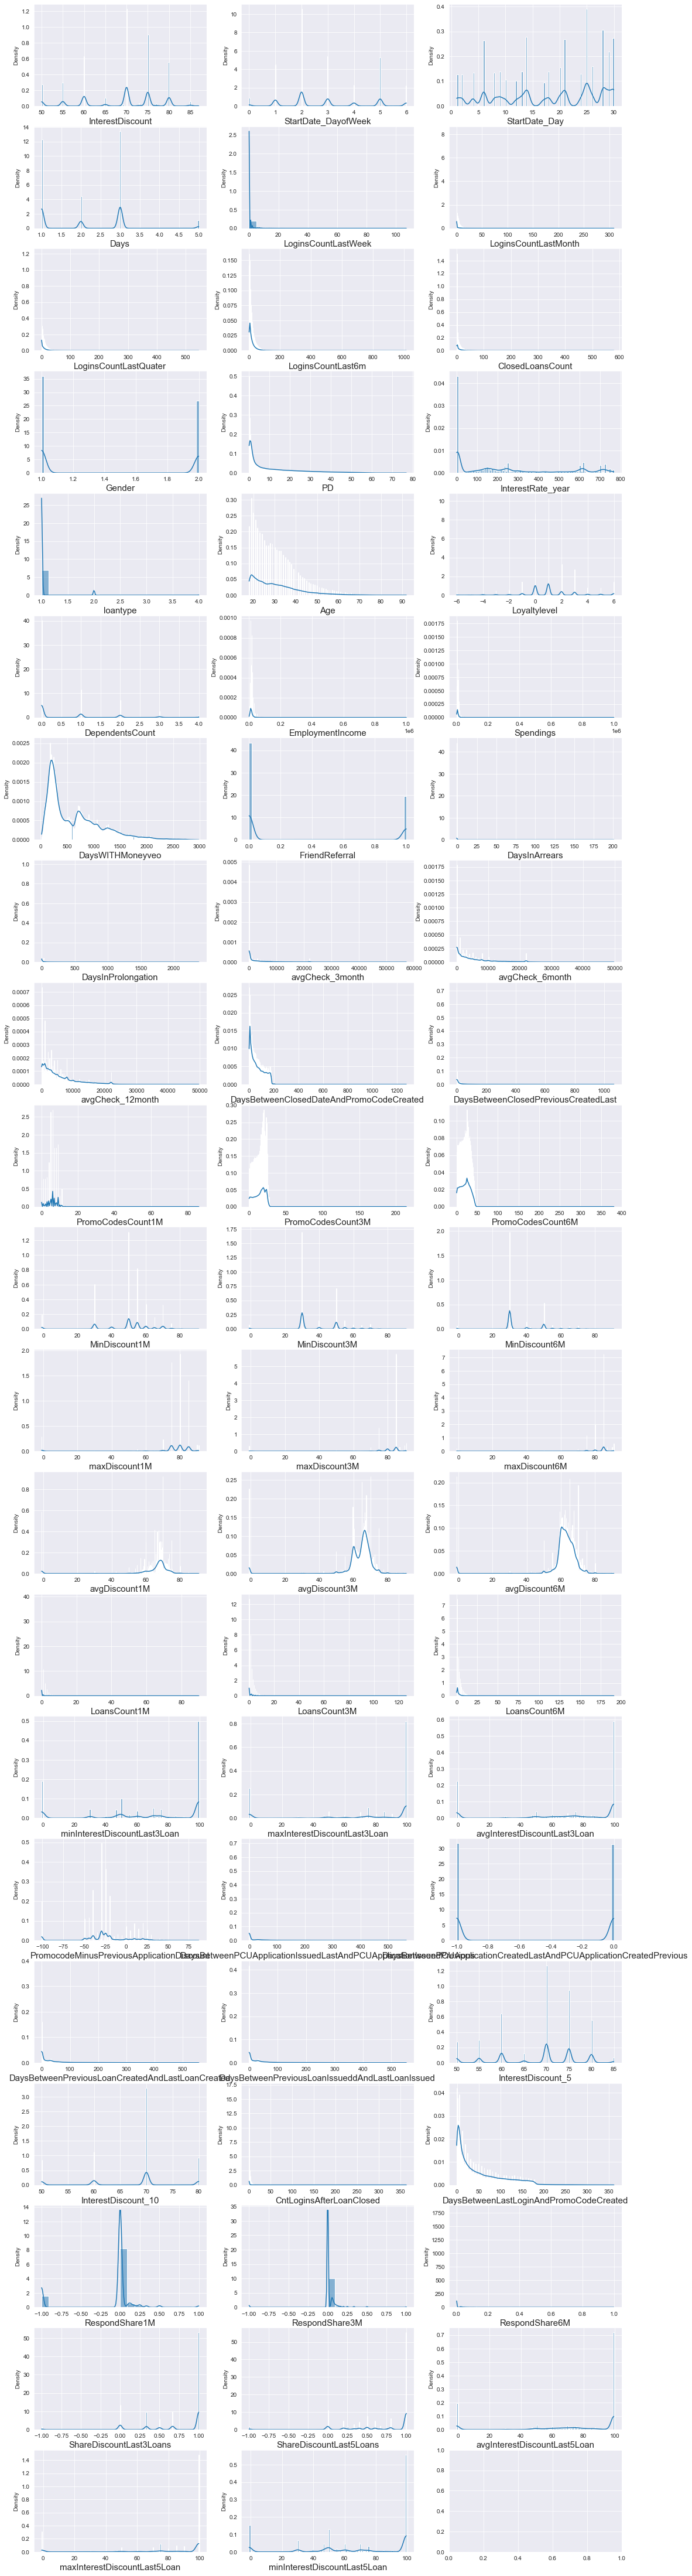

In [46]:
%%time
# Проаналізуємо детальніше числові ознаки 

sns.set_style('darkgrid', {'legend.frameon':True})
fig, axes = plt.subplots(nrows = math.ceil(len(column_numbers)/3), ncols = 3, figsize=(18, 80))

for idx, feat in  enumerate(column_numbers):
    sns.histplot(data[feat], kde = True, stat ="density", linewidth = 1, ax=axes[int(idx / 3), idx % 3])
    axes[int(idx / 3), idx % 3].set_xlabel(feat, fontsize=15)   

##### 2.2. Dependence of numerical features.

In [47]:
# Проаналізуємо кореляцію між числовими ознаками
# Set Working Directory
path = os.chdir('c:\\Users\\Andrei.Konograi\\Promo Score')
print("Working directory is:", os.getcwd())

sales_correlation = data[column_numbers].corr(method='pearson')
sales_correlation.to_csv('Pearson_corr_total.csv', index = True)
sales_correlation

Working directory is: C:\Users\Andrei.Konograi\Promo Score


InterestDiscount  \
InterestDiscount                                            1.000000   
StartDate_DayofWeek                                         0.358096   
StartDate_Day                                               0.568977   
Days                                                       -0.257233   
LoginsCountLastWeek                                         0.000589   
LoginsCountLastMonth                                       -0.005264   
LoginsCountLastQuater                                      -0.012887   
LoginsCountLast6m                                          -0.005401   
ClosedLoansCount                                            0.001748   
Gender                                                      0.000258   
PD                                                         -0.016254   
InterestRate_year                                          -0.016868   
loantype                                                   -0.007509   
Age                                                        -0.002012   
Loyaltylevel                                                0.002643   
DependentsCount                                            -0.002020   
EmploymentIncome                                            0.000343   
Spendings                                                   0.001584   
DaysWITHMoneyveo                                           -0.012215   
FriendReferral                                              0.003970   
DaysInArrears                                              -0.047960   
DaysInProlongation                                         -0.008077   
avgCheck_3month                                            -0.031357   
avgCheck_6month                                            -0.009518   
avgCheck_12month                                           -0.004929   
DaysBetweenClosedDateAndPromoCodeCreated                    0.047308   
DaysBetweenClosedPreviousCreatedLast                        0.003224   
PromoCodesCount1M                                           0.048462   
PromoCodesCount3M                                           0.007788   
PromoCodesCount6M                                           0.090358   
MinDiscount1M                                               0.078849   
MinDiscount3M                                               0.088607   
MinDiscount6M                                               0.043171   
maxDiscount1M                                               0.006351   
maxDiscount3M                                               0.010114   
maxDiscount6M                                               0.018296   
avgDiscount1M                                               0.023898   
avgDiscount3M                                               0.085713   
avgDiscount6M                                               0.064233   
LoansCount1M                                               -0.065944   
LoansCount3M                                               -0.052677   
LoansCount6M                                               -0.033946   
minInterestDiscountLast3Loan                                0.012955   
maxInterestDiscountLast3Loan                                0.010835   
avgInterestDiscountLast3Loan                                0.012202   
PromocodeMinusPreviousApplicationDiscount                   0.279385   
DaysBetweenPCUApplicationIssuedLastAndPCUApplic...          0.002004   
DaysBetweenPCUApplicationCreatedLastAndPCUAppli...         -0.002934   
DaysBetweenPreviousLoanCreatedAndLastLoanCreated            0.007163   
DaysBetweenPreviousLoanIssueddAndLastLoanIssued             0.007966   
InterestDiscount_5                                          0.998572   
InterestDiscount_10                                         0.961712   
CntLoginsAfterLoanClosed                                    0.005007   
DaysBetweenLastLoginAndPromoCodeCreated                     0.036623   
RespondShare1M                                              0.065475   
RespondShare3M      

<AxesSubplot:title={'center':'Pearson Correlation of features'}>

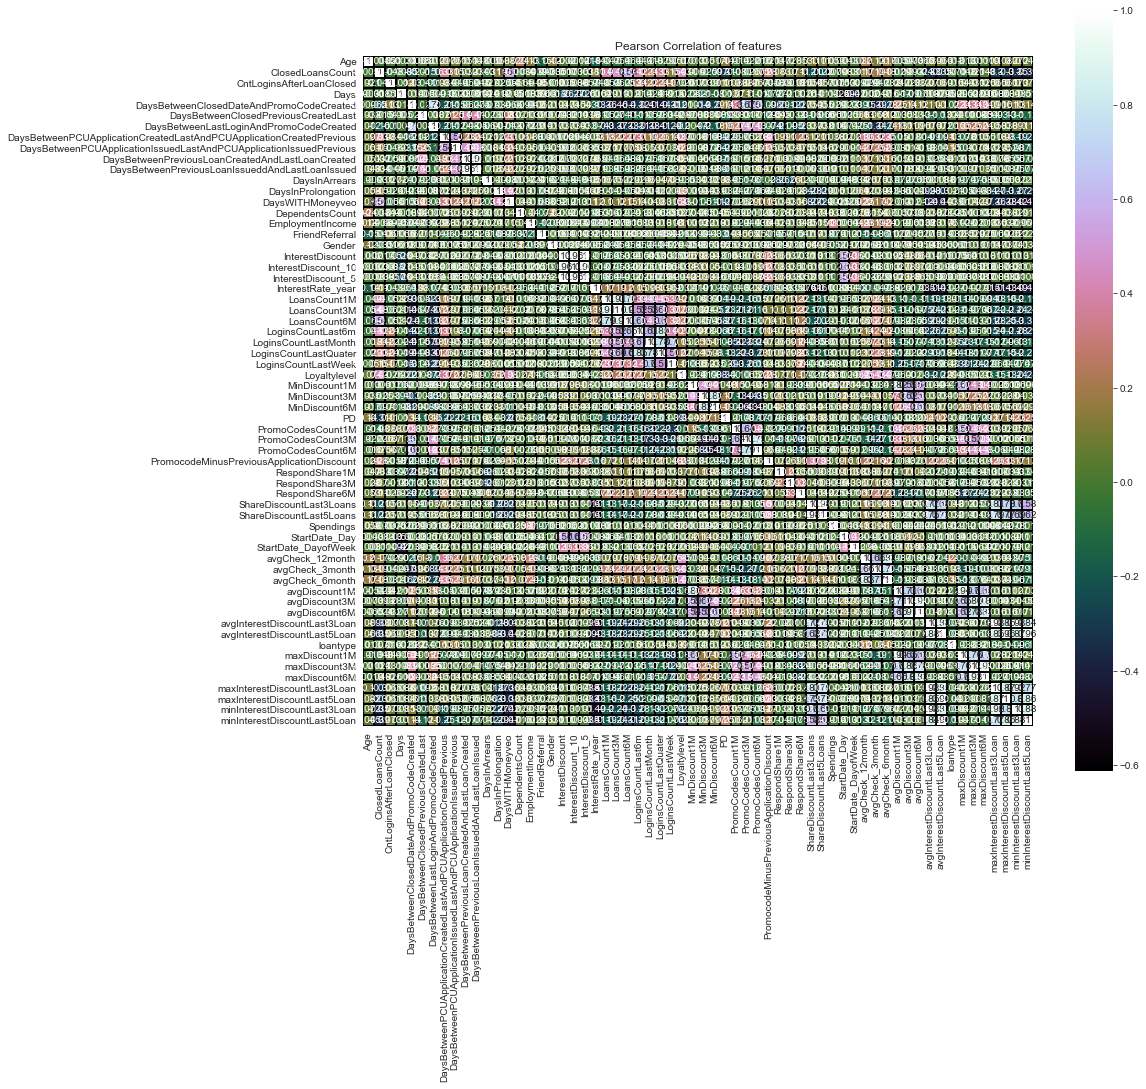

In [48]:
# Візуалізуємо кореляційні значення
str_list = [] # empty list to contain columns with strings (words)
for colname, colvalue in data[column_numbers].iteritems():
    if type(colvalue) == str:   # colvalue[0]
         str_list.append(colname)
# Get to the numeric columns by inversion            
num_list = data[column_numbers].columns.difference(str_list) 
# Create Dataframe containing only numerical features
data_num = data[column_numbers][num_list]
f, ax = plt.subplots(figsize=(15, 14))
plt.title('Pearson Correlation of features')
# Draw the heatmap using seaborn
#sns.heatmap(house_num.astype(float).corr(),linewidths=0.25,vmax=1.0, square=True, cmap="PuBuGn", linecolor='k', annot=True)
sns.heatmap(data_num.astype(float).corr(),linewidths=0.25,vmax=1.0, square=True, cmap="cubehelix", linecolor='k', annot=True)

In [51]:
# Проаналізуємо кореляцію числових ознак з цільовою змінною:
correlations_data = data_total[column_numbers + ['isCreated']].corr()['isCreated']
correlations_data = correlations_data.sort_values(ascending=False)
correlations_data.iloc[1:]

RespondShare6M                                                          0.380843
LoansCount1M                                                            0.204604
LoansCount3M                                                            0.200432
RespondShare3M                                                          0.186804
LoginsCountLastMonth                                                    0.179492
avgCheck_3month                                                         0.178942
LoansCount6M                                                            0.178023
LoginsCountLastWeek                                                     0.175890
LoginsCountLastQuater                                                   0.163047
LoginsCountLast6m                                                       0.137266
DaysBetweenPCUApplicationCreatedLastAndPCUApplicationCreatedPrevious    0.132089
avgCheck_6month                                                         0.129012
Loyaltylevel                

##### 2.3. Correlation of numeric features with a target variable.

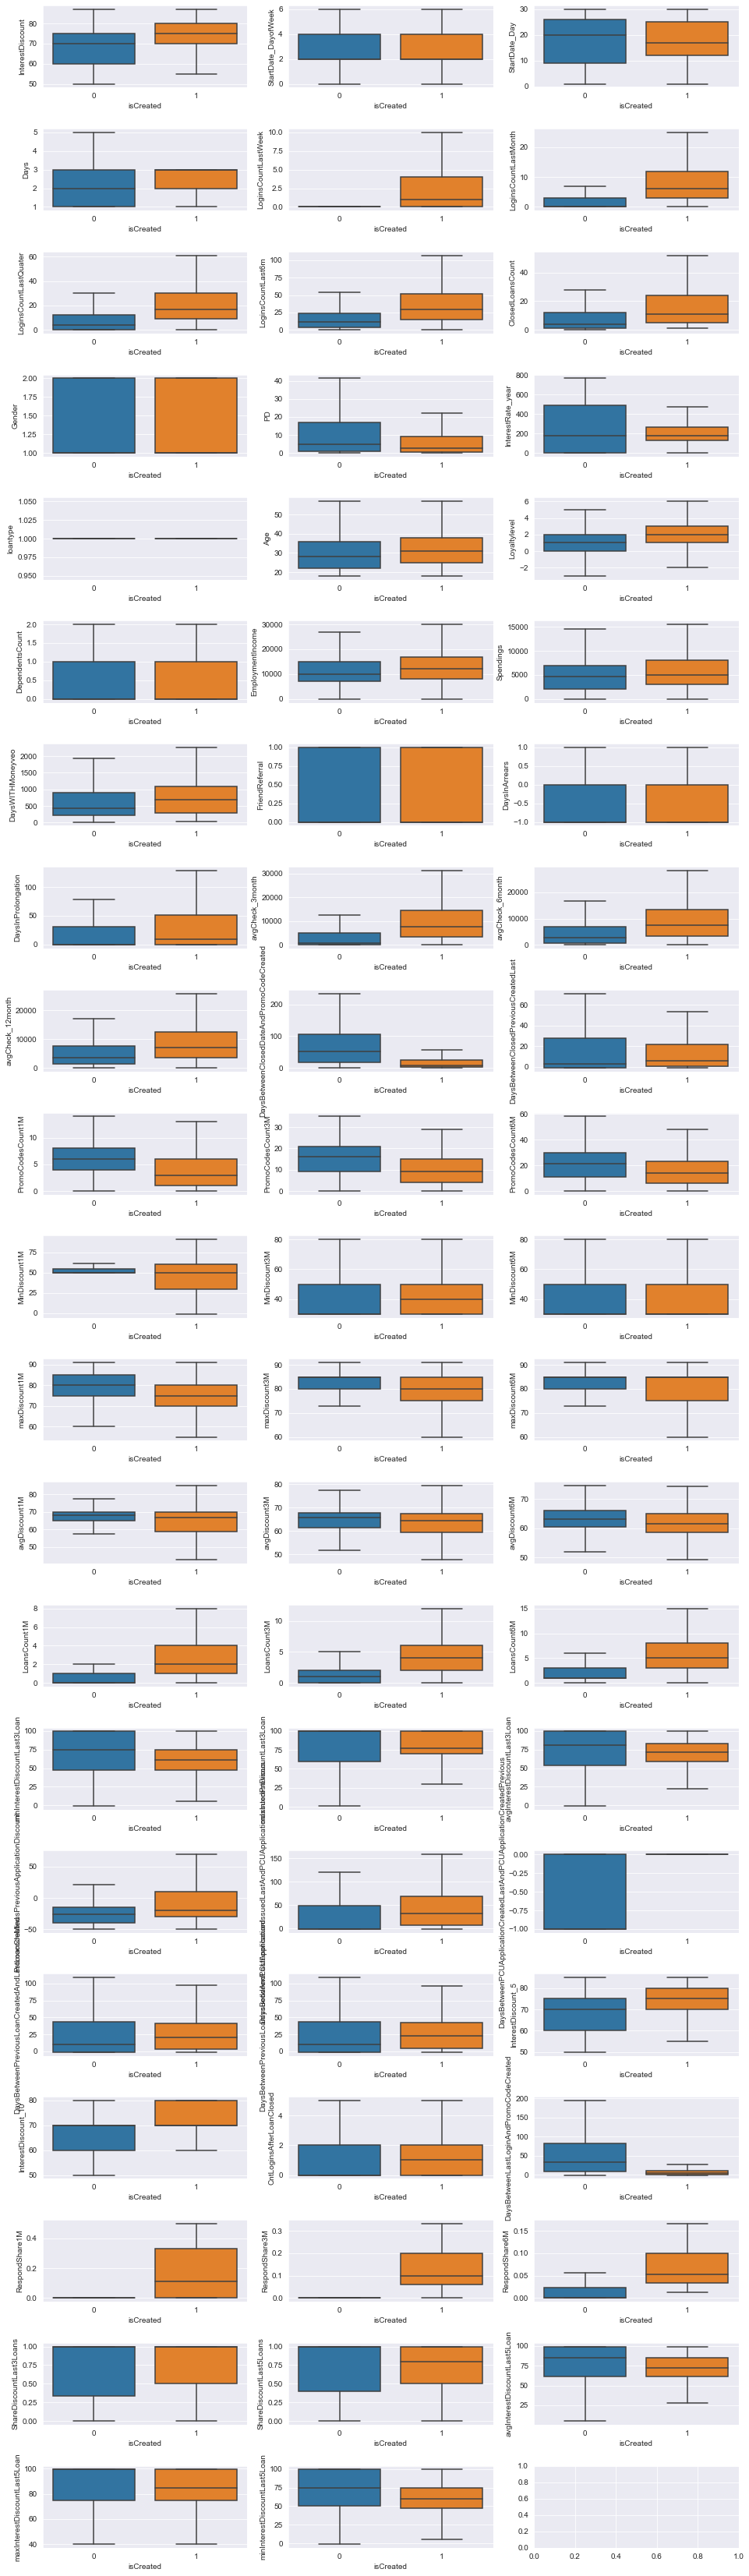

In [53]:
# Відкинемо викиди, за допомогою команди "sym=''"
sns.set_style('darkgrid', {'legend.frameon':True})
fig, axes = plt.subplots(nrows = math.ceil(len(column_numbers)/3), ncols = 3, figsize = (16, 60))
plt.subplots_adjust(hspace = 0.5)

for idx, feat in  enumerate(column_numbers):
    sns.boxplot(x = 'isCreated', y=feat, data = data_total[column_numbers + ["isCreated"]], ax=axes[int(idx / 3), idx % 3],  sym='')
    axes[int(idx / 3), idx % 3].set_xlabel('isCreated')
    axes[int(idx / 3), idx % 3].set_ylabel(feat);

In [54]:
# Undersampling data 
not_Apps = data_total[data_total.isCreated  == 0]
is_Apps = data_total[data_total.isCreated  == 1]

not_Apps_downsampled = resample(not_Apps,
                                replace = False, # sample without replacement
                                n_samples = len(is_Apps), # match minority n
                                random_state = 42) # reproducible results

# combine minority and downsampled majority
data_downsampled = pd.concat([not_Apps_downsampled, is_Apps])

# checking counts
data_downsampled.isCreated.value_counts()

0    64837
1    64837
Name: isCreated, dtype: int64

C:\Users\Andrei.Konograi\AppData\Roaming\Python\Python37\site-packages\seaborn\axisgrid.py:392: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


Wall time: 44.6 s


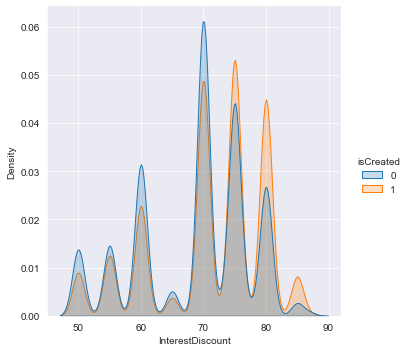

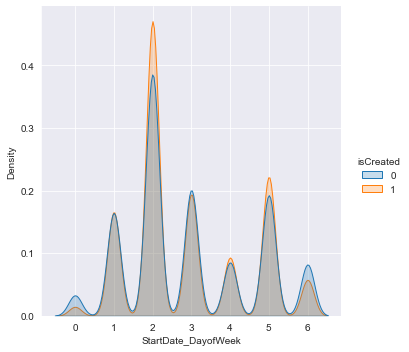

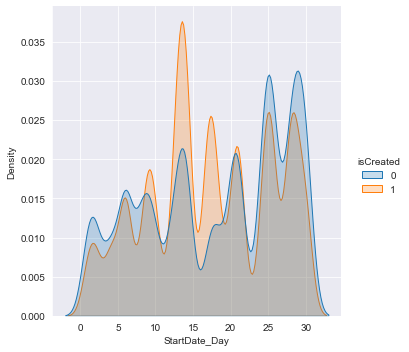

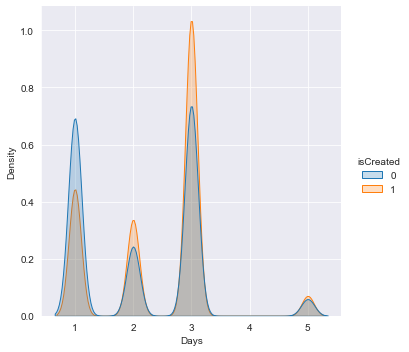

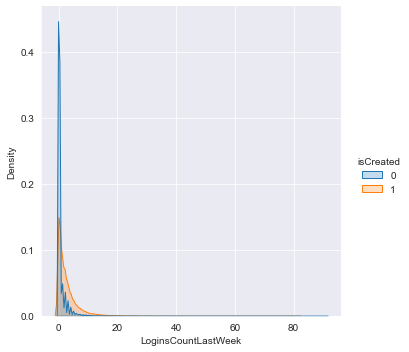

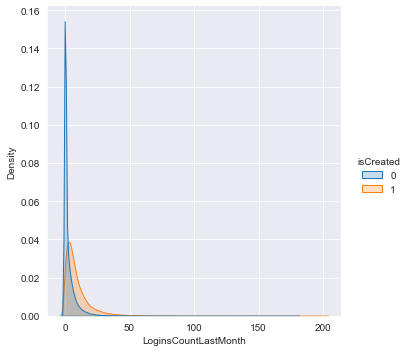

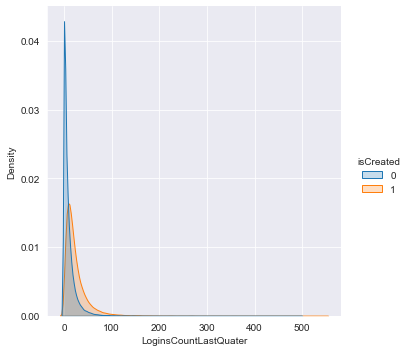

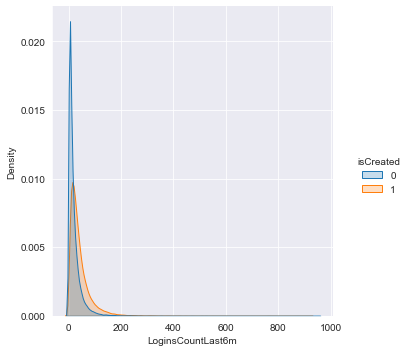

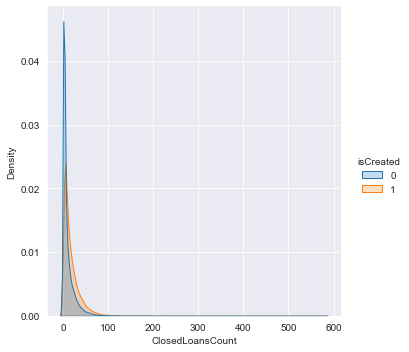

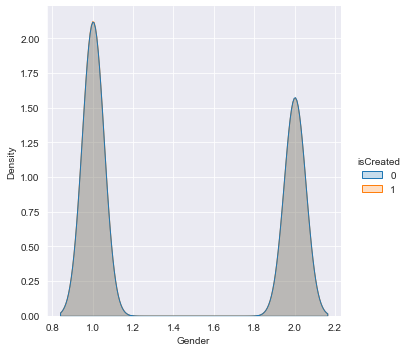

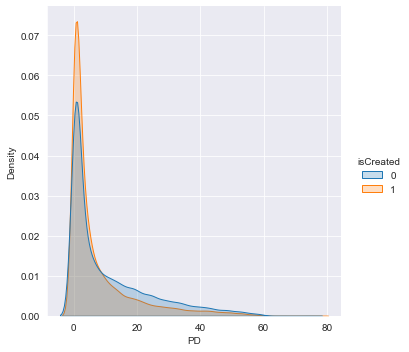

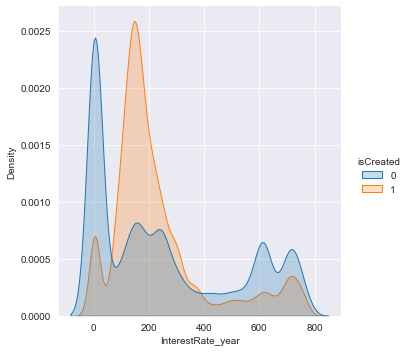

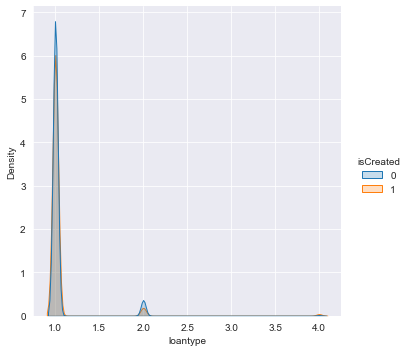

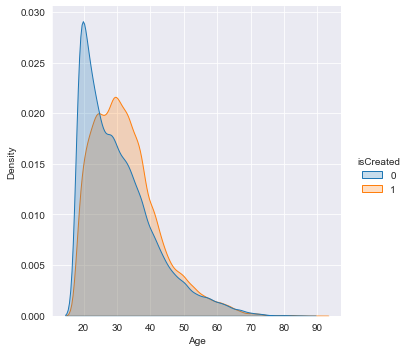

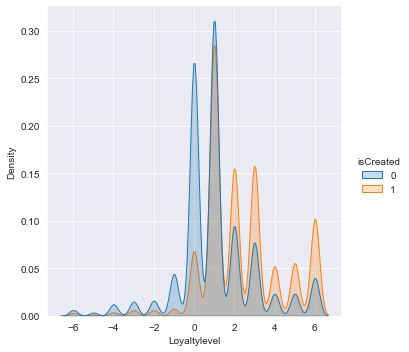

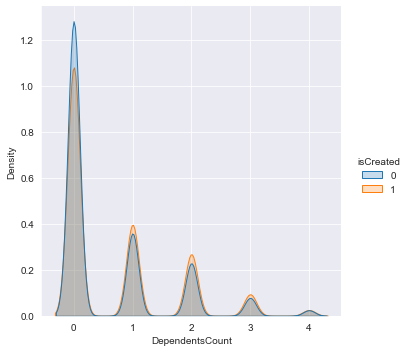

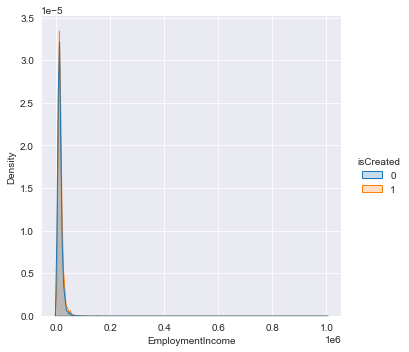

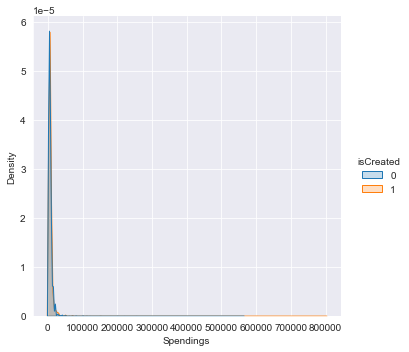

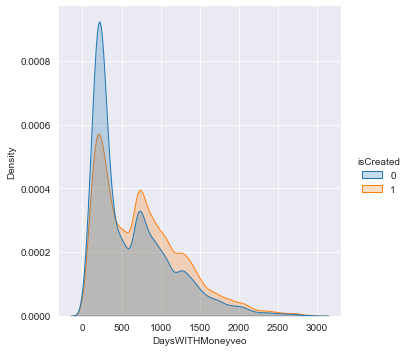

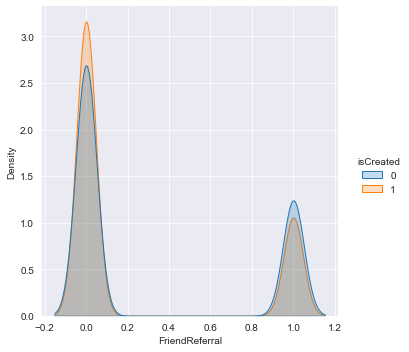

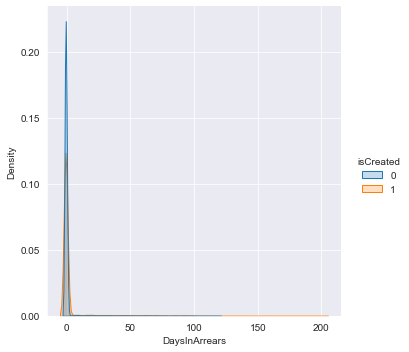

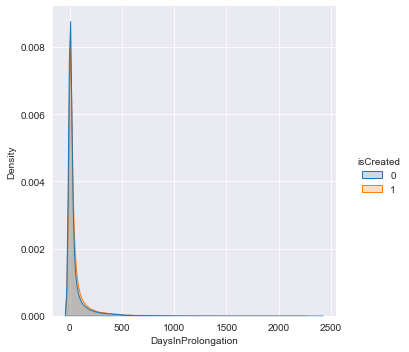

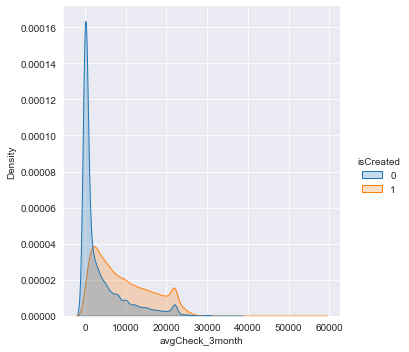

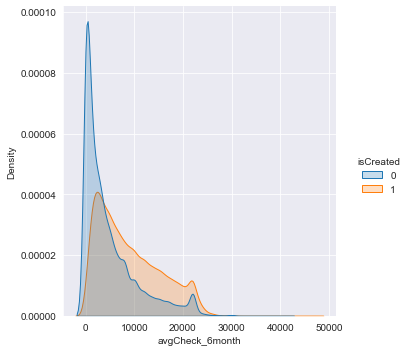

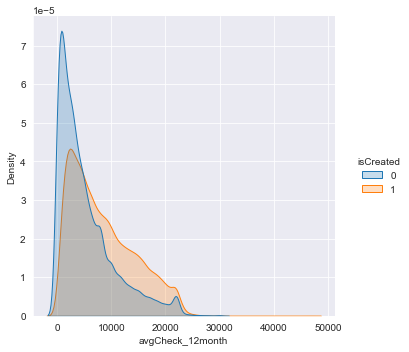

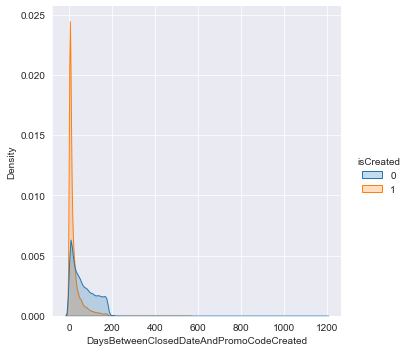

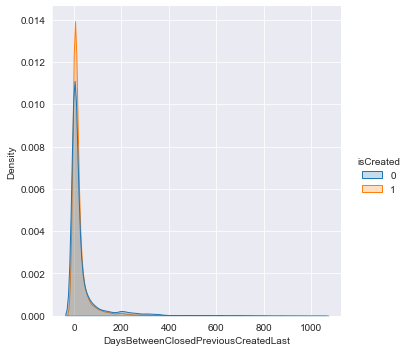

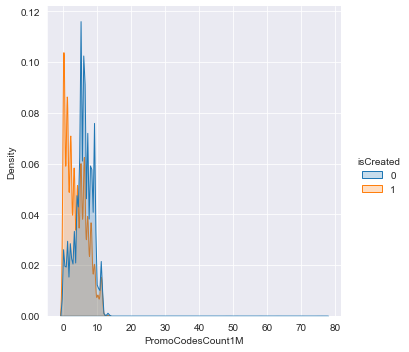

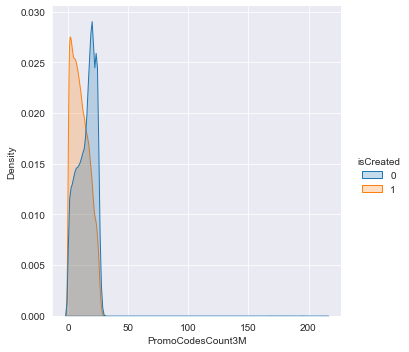

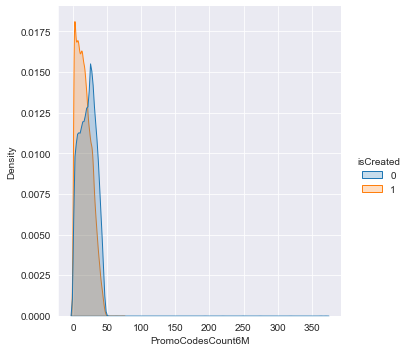

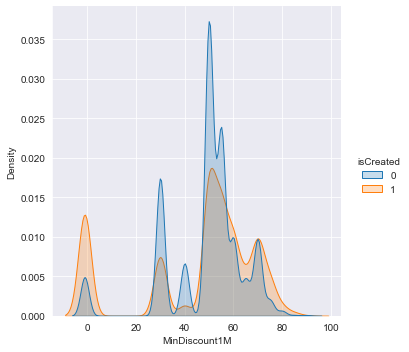

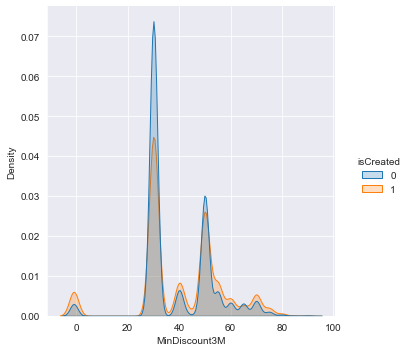

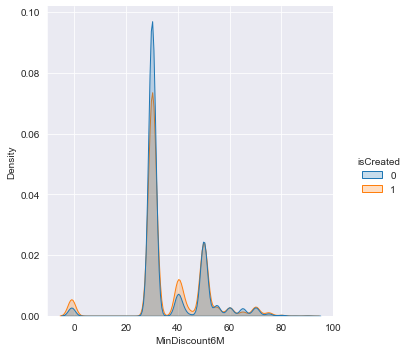

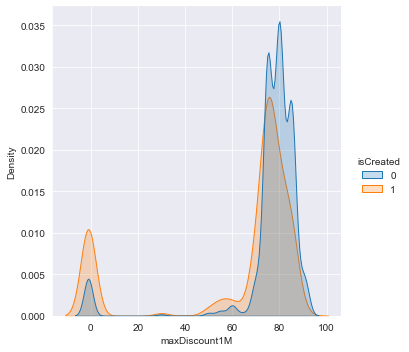

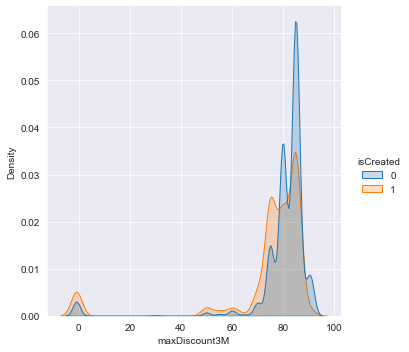

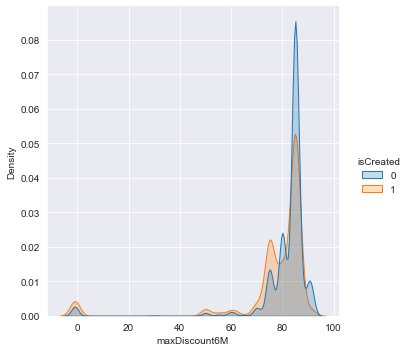

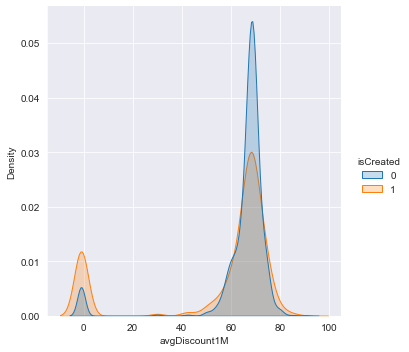

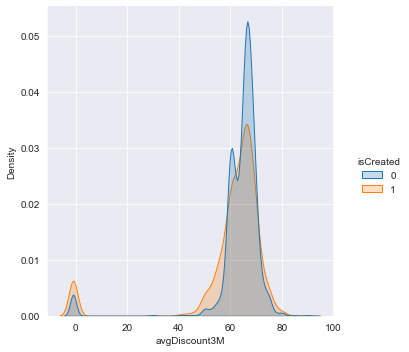

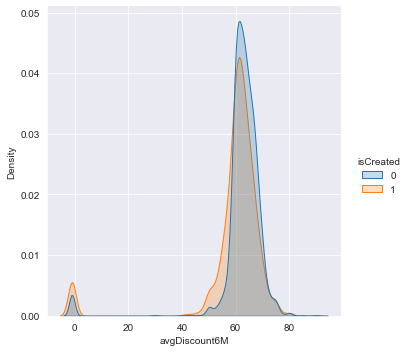

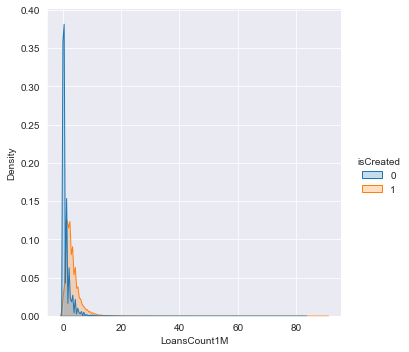

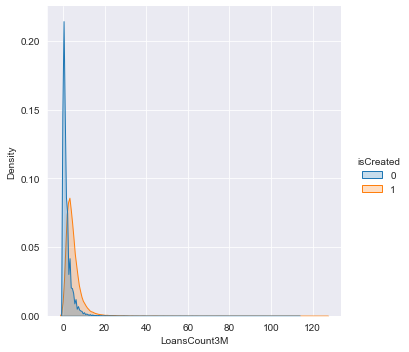

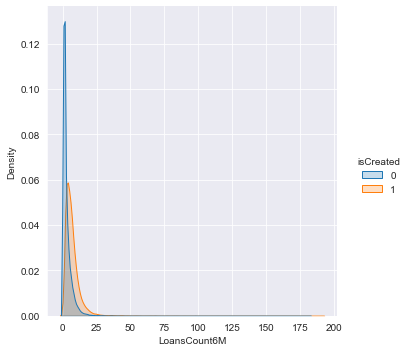

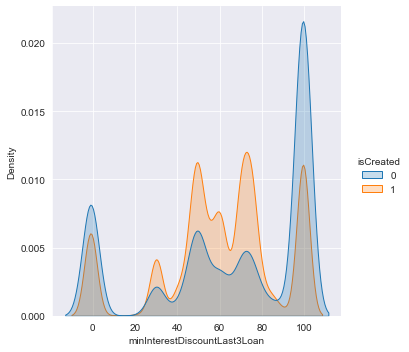

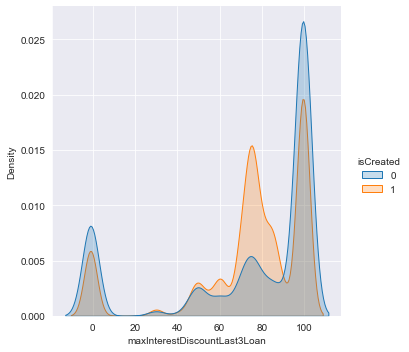

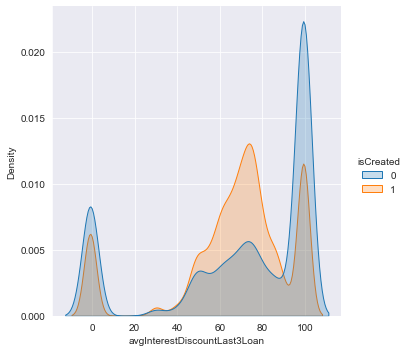

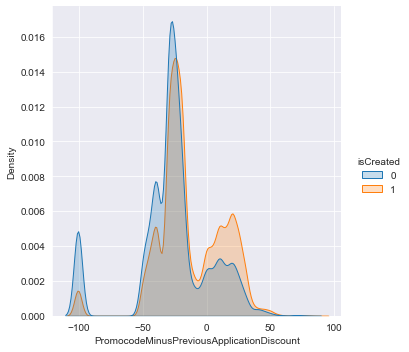

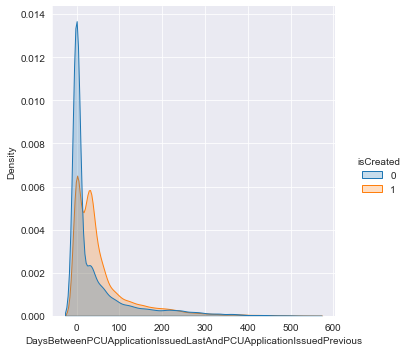

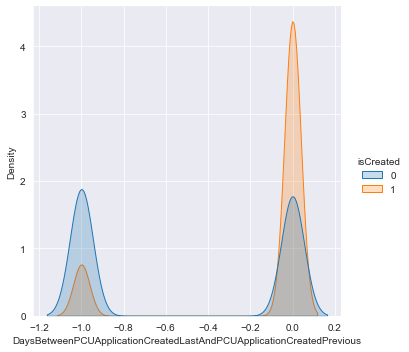

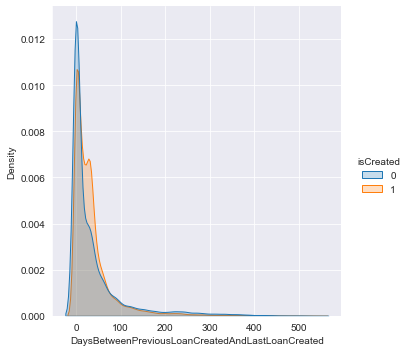

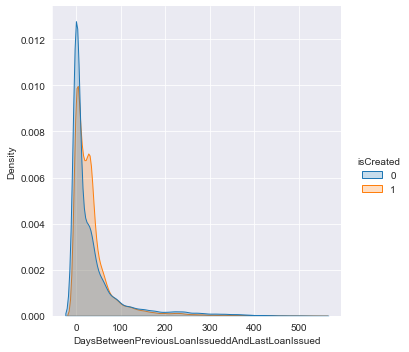

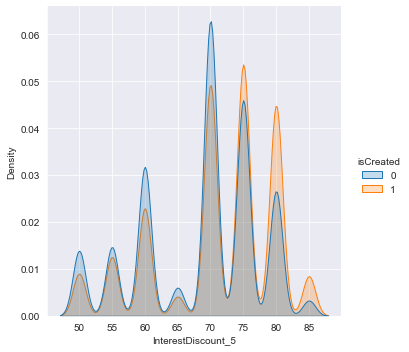

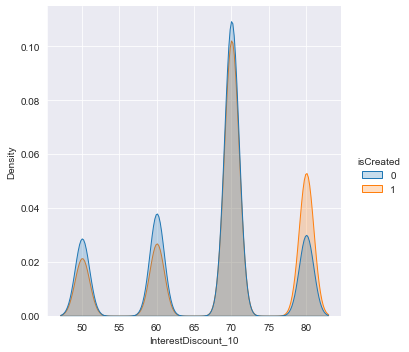

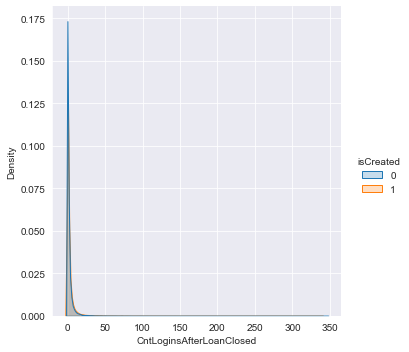

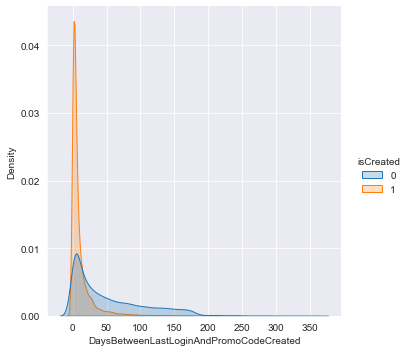

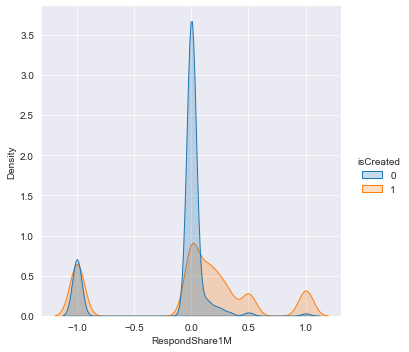

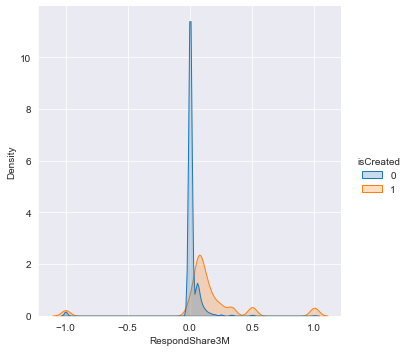

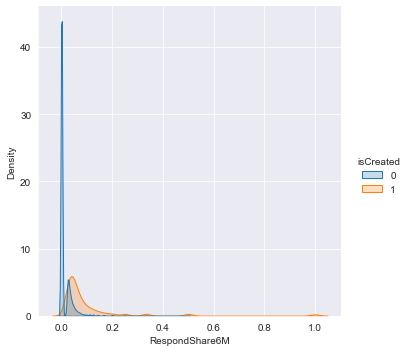

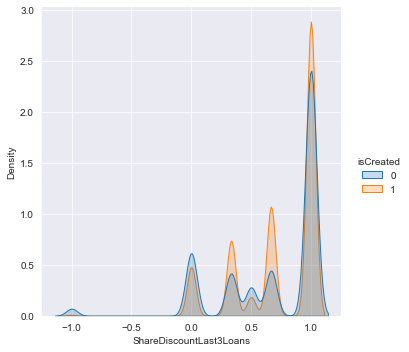

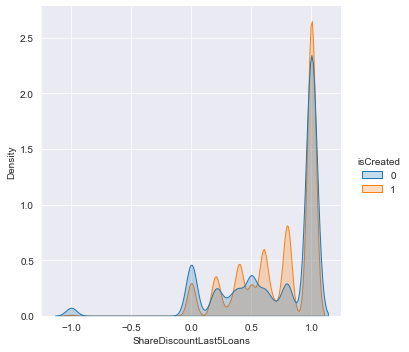

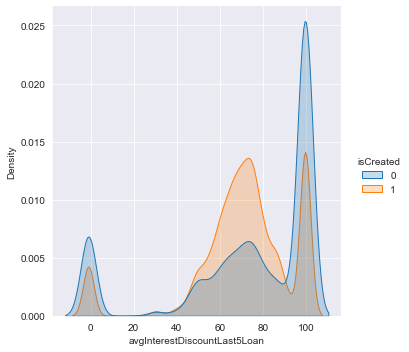

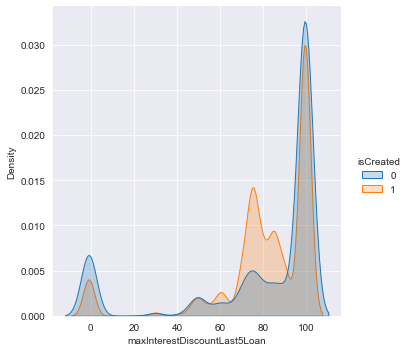

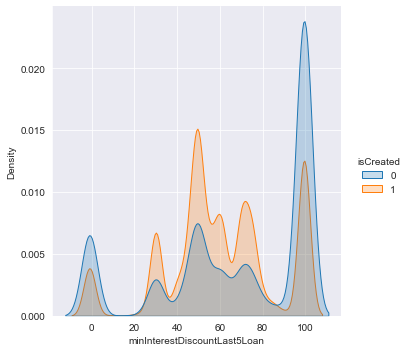

In [55]:
%%time
# Розподіли по цільовій 
for idx, feat in  enumerate(column_numbers):
    sns.displot(data_downsampled, 
                x = feat, 
                hue = "isCreated", 
                kind ="kde", 
                fill = True)

### 3. Feature handling.¶

##### 3.1. Encoding categorical features.

In [178]:
# Генеруємо категоріальні ознаки
data_total_cat = data[column_categorical]

print("Shape categorical table: ", data_total_cat.shape)

Shape categorical table:  (1923539, 7)


In [179]:
%%time

# We use Ordinal Encoder 
OE = OrdinalEncoder().fit(data_total_cat)
 
data_total_cat_OE = OE.transform(data_total_cat)

# # Active path
path = os.chdir('C:\\Users\\Andrei.Konograi\\Promo Score\\Save_Models')
print("Working directory is:", os.getcwd())

# # Save encoder for Prediction coding
pickle.dump(OE, open("OE_Total.pkl","wb"))

data_total_cat_OE.head()

Working directory is: C:\Users\Andrei.Konograi\Promo Score\Save_Models
Wall time: 7.06 s


PreviousStatusGroupName  Region  MaritalStatus  Education  \
0                        1       1              1          1   
1                        1       2              2          1   
2                        1       1              1          1   
3                        1       3              1          1   
5                        2       4              2          1   

   EmploymentIndustry  EmploymentStatus  cpa  
0                   1                 1    1  
1                   2                 2    2  
2                   1                 1    1  
3                   1                 3    3  
5                   2                 1    3

In [180]:
OE.category_mapping

[{'col': 'PreviousStatusGroupName',
  'mapping': Live          1
  Arrears       2
  InProgress    3
  Declined      4
  NaN          -2
  dtype: int64,
  'data_type': dtype('O')},
 {'col': 'Region',
  'mapping': Lutsk                         1
  Kirovograd                    2
  Sumy                          3
  Kherson                       4
  Zaporozhye                    5
  Dnepropetrovsk                6
  Uzhgorod                      7
  Chernihiv                     8
  Kyivska oblast                9
  Hmelnickii                   10
  Kharkiv                      11
  Poltava                      12
  Donetsk                      13
  Vinnitsa                     14
  Chernivtsi                   15
  Ternopil                     16
  Odessa                       17
  Kiev                         18
  IvanoFrankovsk               19
  Rivne                        20
  Cherkasy                     21
  Lugansk                      22
  Lviv                         23
  Zhito

##### 3.2. Merge numerical and categorical features.

In [181]:
# Об'єднуємо таблиці:
######################################## No Scaled #####################################
data_train = pd.concat([data[column_numbers], data_total_cat_OE], axis = 1)

print("############################## No Scaled tables ###############################")
print("Total Train-Test shape: ", data_train.shape)

############################## No Scaled tables ###############################
Total Train-Test shape:  (1923539, 69)


##### 3.3.Train/Val/Test split.

In [182]:
# Розбиваємо дані НЕ нормалізовані на Train/Val_Test при цьому зберігаємо співвідношення класів
X_train, X_val_test, y_train, y_val_test = train_test_split(data_train, 
                                                                 data_total['isCreated'].values, 
                                                                 test_size = 0.4, 
                                                                 random_state = 42,
                                                                 stratify = data_total['isCreated'].values)
# Перевіримо збалансованість класів
print('Total data: ', sum(data_total['isCreated'].values)/len(data_total['isCreated'].values)*100)
print('Train data: ', sum(y_train)/len(y_train)*100)
print('Test data: ', sum(y_val_test)/len(y_val_test)*100)

Total data:  3.3707140848196997
Train data:  3.3706979238781307
Test data:  3.3707383262110486


In [183]:
# Розбиваємо дані НЕ нормалізовані на Train/Val_Test при цьому зберігаємо співвідношення класів
X_val, X_test, y_val, y_test = train_test_split(X_val_test, 
                                                y_val_test, 
                                                test_size = 0.5, 
                                                random_state = 42,
                                                stratify = y_val_test)
# Перевіримо збалансованість класів
print('--------------------------------------')
print('Total Data examples: ', len(data_total))
print('Total Train examples: ', len(X_train))
print('Total Val examples: ', len(X_val))
print('Total Test examples: ', len(X_test))
print('--------------------------------------')
print('Share Total data: ', sum(data_total['isCreated'].values)/len(data_total['isCreated'].values)*100)
print('Share Train data: ', sum(y_train)/len(y_train)*100)
print('Share Val data: ', sum(y_val)/len(y_val)*100)
print('Share Test data: ', sum(y_test)/len(y_test)*100)

--------------------------------------
Total Data examples:  1923539
Total Train examples:  1154123
Total Val examples:  384708
Total Test examples:  384708
--------------------------------------
Share Total data:  3.3707140848196997
Share Train data:  3.3706979238781307
Share Val data:  3.370868294914585
Share Test data:  3.3706083575075123


### 4. XGBoost model.

###### 4.1. Grid Search.

In [73]:
%%time
# Проведемо підбір параметрів для XGBoost
# Означимо сітку параметрів:
params_XGBoost =[ 
    {'max_depth' : [3], 
          'n_estimators' : arange(100, 1100, 100),
          'objective' : ['binary:logistic'],
          'random_state' : [42],
          'reg_alpha':[1e-5, 1e-2, 0],
          'learning_rate': [0.01, 0.1, 0.3],
          'n_jobs' : [-1]},
     {'max_depth' : [4], 
          'n_estimators' : arange(100, 800, 100),
          'objective' : ['binary:logistic'],
          'random_state' : [42],
          'reg_alpha':[1e-5, 1e-2, 0],
          'learning_rate': [0.01, 0.1, 0.3],
          'n_jobs' : [-1]},
     {'max_depth' : [5], 
          'n_estimators' : arange(100, 500, 100),
          'objective' : ['binary:logistic'],
          'random_state' : [42],
          'reg_alpha':[1e-5, 1e-2, 0],
          'learning_rate': [0.01, 0.1, 0.3],
          'n_jobs' : [-1]}
                ]

Wall time: 0 ns


In [74]:
%%time
   
model_XGBoost = xgb.XGBClassifier()
CV_XGBoost = GridSearchCV(estimator=model_XGBoost, 
                          param_grid = params_XGBoost, 
                          cv = 3, 
                          scoring = 'roc_auc',
                          verbose = 3)

CV_XGBoost.fit(X_train, y_train)

print('\n Best estimator:', CV_XGBoost.best_estimator_)
print('\n Best hyperparameters:', CV_XGBoost.best_params_)
print('\n Best score:', CV_XGBoost.best_score_)

Fitting 3 folds for each of 387 candidates, totalling 1161 fits
[CV] learning_rate=0.01, max_depth=3, n_estimators=50, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=1e-05 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  learning_rate=0.01, max_depth=3, n_estimators=50, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=1e-05, score=0.945, total=  27.3s
[CV] learning_rate=0.01, max_depth=3, n_estimators=50, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=1e-05 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   27.3s remaining:    0.0s


[CV]  learning_rate=0.01, max_depth=3, n_estimators=50, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=1e-05, score=0.944, total=  27.2s
[CV] learning_rate=0.01, max_depth=3, n_estimators=50, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=1e-05 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   54.6s remaining:    0.0s


[CV]  learning_rate=0.01, max_depth=3, n_estimators=50, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=1e-05, score=0.943, total=  27.5s
[CV] learning_rate=0.01, max_depth=3, n_estimators=50, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=0.01 
[CV]  learning_rate=0.01, max_depth=3, n_estimators=50, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=0.01, score=0.945, total=  27.8s
[CV] learning_rate=0.01, max_depth=3, n_estimators=50, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=0.01 
[CV]  learning_rate=0.01, max_depth=3, n_estimators=50, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=0.01, score=0.944, total=  26.7s
[CV] learning_rate=0.01, max_depth=3, n_estimators=50, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=0.01 
[CV]  learning_rate=0.01, max_depth=3, n_estimators=50, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=0.01, score=0.943, total=  27.5s
[CV] 

[CV]  learning_rate=0.01, max_depth=3, n_estimators=200, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=0.01, score=0.949, total= 1.7min
[CV] learning_rate=0.01, max_depth=3, n_estimators=200, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=0 
[CV]  learning_rate=0.01, max_depth=3, n_estimators=200, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=0, score=0.951, total= 1.7min
[CV] learning_rate=0.01, max_depth=3, n_estimators=200, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=0 
[CV]  learning_rate=0.01, max_depth=3, n_estimators=200, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=0, score=0.950, total= 1.7min
[CV] learning_rate=0.01, max_depth=3, n_estimators=200, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=0 
[CV]  learning_rate=0.01, max_depth=3, n_estimators=200, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=0, score=0.949, total= 1.7min
[CV] learning_rat

[CV]  learning_rate=0.01, max_depth=3, n_estimators=350, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=0, score=0.953, total= 2.9min
[CV] learning_rate=0.01, max_depth=3, n_estimators=400, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=1e-05 
[CV]  learning_rate=0.01, max_depth=3, n_estimators=400, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=1e-05, score=0.956, total= 3.1min
[CV] learning_rate=0.01, max_depth=3, n_estimators=400, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=1e-05 
[CV]  learning_rate=0.01, max_depth=3, n_estimators=400, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=1e-05, score=0.955, total= 3.1min
[CV] learning_rate=0.01, max_depth=3, n_estimators=400, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=1e-05 
[CV]  learning_rate=0.01, max_depth=3, n_estimators=400, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=1e-05, score=0.954, total= 3.2

[CV]  learning_rate=0.01, max_depth=3, n_estimators=550, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=1e-05, score=0.955, total= 4.2min
[CV] learning_rate=0.01, max_depth=3, n_estimators=550, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=0.01 
[CV]  learning_rate=0.01, max_depth=3, n_estimators=550, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=0.01, score=0.957, total= 4.4min
[CV] learning_rate=0.01, max_depth=3, n_estimators=550, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=0.01 
[CV]  learning_rate=0.01, max_depth=3, n_estimators=550, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=0.01, score=0.956, total= 4.3min
[CV] learning_rate=0.01, max_depth=3, n_estimators=550, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=0.01 
[CV]  learning_rate=0.01, max_depth=3, n_estimators=550, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=0.01, score=0.955, total= 4.3mi

[CV]  learning_rate=0.01, max_depth=3, n_estimators=700, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=0.01, score=0.956, total= 5.3min
[CV] learning_rate=0.01, max_depth=3, n_estimators=700, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=0 
[CV]  learning_rate=0.01, max_depth=3, n_estimators=700, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=0, score=0.958, total= 5.5min
[CV] learning_rate=0.01, max_depth=3, n_estimators=700, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=0 
[CV]  learning_rate=0.01, max_depth=3, n_estimators=700, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=0, score=0.957, total= 5.3min
[CV] learning_rate=0.01, max_depth=3, n_estimators=700, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=0 
[CV]  learning_rate=0.01, max_depth=3, n_estimators=700, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=0, score=0.956, total= 5.4min
[CV] learning_rat

[CV]  learning_rate=0.01, max_depth=3, n_estimators=850, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=0, score=0.958, total= 6.4min
[CV] learning_rate=0.01, max_depth=3, n_estimators=900, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=1e-05 
[CV]  learning_rate=0.01, max_depth=3, n_estimators=900, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=1e-05, score=0.960, total= 7.2min
[CV] learning_rate=0.01, max_depth=3, n_estimators=900, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=1e-05 
[CV]  learning_rate=0.01, max_depth=3, n_estimators=900, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=1e-05, score=0.959, total= 7.2min
[CV] learning_rate=0.01, max_depth=3, n_estimators=900, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=1e-05 
[CV]  learning_rate=0.01, max_depth=3, n_estimators=900, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=1e-05, score=0.959, total= 7.3

[CV]  learning_rate=0.1, max_depth=3, n_estimators=50, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=1e-05, score=0.955, total=  26.5s
[CV] learning_rate=0.1, max_depth=3, n_estimators=50, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=0.01 
[CV]  learning_rate=0.1, max_depth=3, n_estimators=50, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=0.01, score=0.956, total=  25.3s
[CV] learning_rate=0.1, max_depth=3, n_estimators=50, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=0.01 
[CV]  learning_rate=0.1, max_depth=3, n_estimators=50, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=0.01, score=0.955, total=  26.2s
[CV] learning_rate=0.1, max_depth=3, n_estimators=50, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=0.01 
[CV]  learning_rate=0.1, max_depth=3, n_estimators=50, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=0.01, score=0.955, total=  25.9s
[CV] learnin

[CV]  learning_rate=0.1, max_depth=3, n_estimators=200, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=0.01, score=0.964, total= 1.6min
[CV] learning_rate=0.1, max_depth=3, n_estimators=200, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=0 
[CV]  learning_rate=0.1, max_depth=3, n_estimators=200, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=0, score=0.965, total= 1.6min
[CV] learning_rate=0.1, max_depth=3, n_estimators=200, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=0 
[CV]  learning_rate=0.1, max_depth=3, n_estimators=200, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=0, score=0.965, total= 1.7min
[CV] learning_rate=0.1, max_depth=3, n_estimators=200, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=0 
[CV]  learning_rate=0.1, max_depth=3, n_estimators=200, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=0, score=0.964, total= 1.6min
[CV] learning_rate=0.1, 

[CV]  learning_rate=0.1, max_depth=3, n_estimators=350, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=0, score=0.969, total= 2.7min
[CV] learning_rate=0.1, max_depth=3, n_estimators=400, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=1e-05 
[CV]  learning_rate=0.1, max_depth=3, n_estimators=400, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=1e-05, score=0.970, total= 3.2min
[CV] learning_rate=0.1, max_depth=3, n_estimators=400, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=1e-05 
[CV]  learning_rate=0.1, max_depth=3, n_estimators=400, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=1e-05, score=0.970, total= 3.2min
[CV] learning_rate=0.1, max_depth=3, n_estimators=400, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=1e-05 
[CV]  learning_rate=0.1, max_depth=3, n_estimators=400, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=1e-05, score=0.970, total= 3.2min
[CV

[CV]  learning_rate=0.1, max_depth=3, n_estimators=550, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=1e-05, score=0.971, total= 4.3min
[CV] learning_rate=0.1, max_depth=3, n_estimators=550, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=0.01 
[CV]  learning_rate=0.1, max_depth=3, n_estimators=550, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=0.01, score=0.972, total= 4.5min
[CV] learning_rate=0.1, max_depth=3, n_estimators=550, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=0.01 
[CV]  learning_rate=0.1, max_depth=3, n_estimators=550, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=0.01, score=0.971, total= 4.3min
[CV] learning_rate=0.1, max_depth=3, n_estimators=550, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=0.01 
[CV]  learning_rate=0.1, max_depth=3, n_estimators=550, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=0.01, score=0.971, total= 4.4min
[CV] 

[CV]  learning_rate=0.1, max_depth=3, n_estimators=700, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=0.01, score=0.973, total= 5.4min
[CV] learning_rate=0.1, max_depth=3, n_estimators=700, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=0 
[CV]  learning_rate=0.1, max_depth=3, n_estimators=700, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=0, score=0.973, total= 5.5min
[CV] learning_rate=0.1, max_depth=3, n_estimators=700, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=0 
[CV]  learning_rate=0.1, max_depth=3, n_estimators=700, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=0, score=0.973, total= 5.4min
[CV] learning_rate=0.1, max_depth=3, n_estimators=700, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=0 
[CV]  learning_rate=0.1, max_depth=3, n_estimators=700, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=0, score=0.973, total= 5.5min
[CV] learning_rate=0.1, 

[CV]  learning_rate=0.1, max_depth=3, n_estimators=850, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=0, score=0.973, total= 6.6min
[CV] learning_rate=0.1, max_depth=3, n_estimators=900, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=1e-05 
[CV]  learning_rate=0.1, max_depth=3, n_estimators=900, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=1e-05, score=0.974, total= 7.2min
[CV] learning_rate=0.1, max_depth=3, n_estimators=900, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=1e-05 
[CV]  learning_rate=0.1, max_depth=3, n_estimators=900, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=1e-05, score=0.973, total= 7.0min
[CV] learning_rate=0.1, max_depth=3, n_estimators=900, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=1e-05 
[CV]  learning_rate=0.1, max_depth=3, n_estimators=900, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=1e-05, score=0.974, total= 7.3min
[CV

[CV]  learning_rate=0.3, max_depth=3, n_estimators=50, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=1e-05, score=0.963, total=  25.5s
[CV] learning_rate=0.3, max_depth=3, n_estimators=50, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=0.01 
[CV]  learning_rate=0.3, max_depth=3, n_estimators=50, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=0.01, score=0.964, total=  25.7s
[CV] learning_rate=0.3, max_depth=3, n_estimators=50, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=0.01 
[CV]  learning_rate=0.3, max_depth=3, n_estimators=50, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=0.01, score=0.963, total=  25.9s
[CV] learning_rate=0.3, max_depth=3, n_estimators=50, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=0.01 
[CV]  learning_rate=0.3, max_depth=3, n_estimators=50, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=0.01, score=0.963, total=  24.8s
[CV] learnin

[CV]  learning_rate=0.3, max_depth=3, n_estimators=200, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=0.01, score=0.972, total= 1.6min
[CV] learning_rate=0.3, max_depth=3, n_estimators=200, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=0 
[CV]  learning_rate=0.3, max_depth=3, n_estimators=200, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=0, score=0.972, total= 1.7min
[CV] learning_rate=0.3, max_depth=3, n_estimators=200, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=0 
[CV]  learning_rate=0.3, max_depth=3, n_estimators=200, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=0, score=0.973, total= 1.6min
[CV] learning_rate=0.3, max_depth=3, n_estimators=200, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=0 
[CV]  learning_rate=0.3, max_depth=3, n_estimators=200, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=0, score=0.972, total= 1.6min
[CV] learning_rate=0.3, 

[CV]  learning_rate=0.3, max_depth=3, n_estimators=350, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=0, score=0.974, total= 2.8min
[CV] learning_rate=0.3, max_depth=3, n_estimators=400, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=1e-05 
[CV]  learning_rate=0.3, max_depth=3, n_estimators=400, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=1e-05, score=0.975, total= 3.2min
[CV] learning_rate=0.3, max_depth=3, n_estimators=400, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=1e-05 
[CV]  learning_rate=0.3, max_depth=3, n_estimators=400, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=1e-05, score=0.975, total= 3.2min
[CV] learning_rate=0.3, max_depth=3, n_estimators=400, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=1e-05 
[CV]  learning_rate=0.3, max_depth=3, n_estimators=400, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=1e-05, score=0.975, total= 3.3min
[CV

[CV]  learning_rate=0.3, max_depth=3, n_estimators=550, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=1e-05, score=0.976, total= 4.3min
[CV] learning_rate=0.3, max_depth=3, n_estimators=550, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=0.01 
[CV]  learning_rate=0.3, max_depth=3, n_estimators=550, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=0.01, score=0.976, total= 4.5min
[CV] learning_rate=0.3, max_depth=3, n_estimators=550, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=0.01 
[CV]  learning_rate=0.3, max_depth=3, n_estimators=550, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=0.01, score=0.976, total= 4.3min
[CV] learning_rate=0.3, max_depth=3, n_estimators=550, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=0.01 
[CV]  learning_rate=0.3, max_depth=3, n_estimators=550, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=0.01, score=0.976, total= 4.5min
[CV] 

[CV]  learning_rate=0.3, max_depth=3, n_estimators=700, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=0.01, score=0.977, total= 5.5min
[CV] learning_rate=0.3, max_depth=3, n_estimators=700, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=0 
[CV]  learning_rate=0.3, max_depth=3, n_estimators=700, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=0, score=0.976, total= 5.7min
[CV] learning_rate=0.3, max_depth=3, n_estimators=700, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=0 
[CV]  learning_rate=0.3, max_depth=3, n_estimators=700, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=0, score=0.977, total= 5.4min
[CV] learning_rate=0.3, max_depth=3, n_estimators=700, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=0 
[CV]  learning_rate=0.3, max_depth=3, n_estimators=700, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=0, score=0.977, total= 5.6min
[CV] learning_rate=0.3, 

[CV]  learning_rate=0.3, max_depth=3, n_estimators=850, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=0, score=0.977, total= 6.9min
[CV] learning_rate=0.3, max_depth=3, n_estimators=900, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=1e-05 
[CV]  learning_rate=0.3, max_depth=3, n_estimators=900, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=1e-05, score=0.977, total= 7.4min
[CV] learning_rate=0.3, max_depth=3, n_estimators=900, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=1e-05 
[CV]  learning_rate=0.3, max_depth=3, n_estimators=900, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=1e-05, score=0.977, total= 7.0min
[CV] learning_rate=0.3, max_depth=3, n_estimators=900, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=1e-05 
[CV]  learning_rate=0.3, max_depth=3, n_estimators=900, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=1e-05, score=0.977, total= 7.3min
[CV

[CV]  learning_rate=0.01, max_depth=4, n_estimators=50, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=1e-05, score=0.949, total=  31.8s
[CV] learning_rate=0.01, max_depth=4, n_estimators=50, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=0.01 
[CV]  learning_rate=0.01, max_depth=4, n_estimators=50, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=0.01, score=0.949, total=  31.9s
[CV] learning_rate=0.01, max_depth=4, n_estimators=50, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=0.01 
[CV]  learning_rate=0.01, max_depth=4, n_estimators=50, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=0.01, score=0.949, total=  31.8s
[CV] learning_rate=0.01, max_depth=4, n_estimators=50, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=0.01 
[CV]  learning_rate=0.01, max_depth=4, n_estimators=50, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=0.01, score=0.949, total=  32.1s
[CV] 

[CV]  learning_rate=0.01, max_depth=4, n_estimators=200, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=0.01, score=0.955, total= 2.0min
[CV] learning_rate=0.01, max_depth=4, n_estimators=200, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=0 
[CV]  learning_rate=0.01, max_depth=4, n_estimators=200, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=0, score=0.957, total= 2.0min
[CV] learning_rate=0.01, max_depth=4, n_estimators=200, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=0 
[CV]  learning_rate=0.01, max_depth=4, n_estimators=200, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=0, score=0.956, total= 2.0min
[CV] learning_rate=0.01, max_depth=4, n_estimators=200, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=0 
[CV]  learning_rate=0.01, max_depth=4, n_estimators=200, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=0, score=0.955, total= 2.0min
[CV] learning_rat

[CV]  learning_rate=0.01, max_depth=4, n_estimators=350, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=0, score=0.958, total= 3.3min
[CV] learning_rate=0.01, max_depth=4, n_estimators=400, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=1e-05 
[CV]  learning_rate=0.01, max_depth=4, n_estimators=400, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=1e-05, score=0.960, total= 3.8min
[CV] learning_rate=0.01, max_depth=4, n_estimators=400, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=1e-05 
[CV]  learning_rate=0.01, max_depth=4, n_estimators=400, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=1e-05, score=0.959, total= 3.9min
[CV] learning_rate=0.01, max_depth=4, n_estimators=400, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=1e-05 
[CV]  learning_rate=0.01, max_depth=4, n_estimators=400, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=1e-05, score=0.959, total= 4.0

[CV]  learning_rate=0.01, max_depth=4, n_estimators=550, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=1e-05, score=0.960, total= 5.2min
[CV] learning_rate=0.01, max_depth=4, n_estimators=550, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=0.01 
[CV]  learning_rate=0.01, max_depth=4, n_estimators=550, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=0.01, score=0.962, total= 5.2min
[CV] learning_rate=0.01, max_depth=4, n_estimators=550, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=0.01 
[CV]  learning_rate=0.01, max_depth=4, n_estimators=550, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=0.01, score=0.961, total= 5.2min
[CV] learning_rate=0.01, max_depth=4, n_estimators=550, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=0.01 
[CV]  learning_rate=0.01, max_depth=4, n_estimators=550, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=0.01, score=0.960, total= 5.1mi

[CV]  learning_rate=0.01, max_depth=4, n_estimators=700, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=0.01, score=0.961, total= 6.4min
[CV] learning_rate=0.01, max_depth=4, n_estimators=700, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=0 
[CV]  learning_rate=0.01, max_depth=4, n_estimators=700, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=0, score=0.963, total= 6.7min
[CV] learning_rate=0.01, max_depth=4, n_estimators=700, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=0 
[CV]  learning_rate=0.01, max_depth=4, n_estimators=700, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=0, score=0.962, total= 6.5min
[CV] learning_rate=0.01, max_depth=4, n_estimators=700, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=0 
[CV]  learning_rate=0.01, max_depth=4, n_estimators=700, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=0, score=0.961, total= 6.6min
[CV] learning_rat

[CV]  learning_rate=0.1, max_depth=4, n_estimators=100, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=0, score=0.964, total=  57.6s
[CV] learning_rate=0.1, max_depth=4, n_estimators=150, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=1e-05 
[CV]  learning_rate=0.1, max_depth=4, n_estimators=150, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=1e-05, score=0.968, total= 1.5min
[CV] learning_rate=0.1, max_depth=4, n_estimators=150, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=1e-05 
[CV]  learning_rate=0.1, max_depth=4, n_estimators=150, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=1e-05, score=0.968, total= 1.4min
[CV] learning_rate=0.1, max_depth=4, n_estimators=150, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=1e-05 
[CV]  learning_rate=0.1, max_depth=4, n_estimators=150, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=1e-05, score=0.968, total= 1.4min
[CV

[CV]  learning_rate=0.1, max_depth=4, n_estimators=300, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=1e-05, score=0.972, total= 2.9min
[CV] learning_rate=0.1, max_depth=4, n_estimators=300, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=0.01 
[CV]  learning_rate=0.1, max_depth=4, n_estimators=300, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=0.01, score=0.973, total= 3.0min
[CV] learning_rate=0.1, max_depth=4, n_estimators=300, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=0.01 
[CV]  learning_rate=0.1, max_depth=4, n_estimators=300, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=0.01, score=0.973, total= 2.9min
[CV] learning_rate=0.1, max_depth=4, n_estimators=300, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=0.01 
[CV]  learning_rate=0.1, max_depth=4, n_estimators=300, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=0.01, score=0.972, total= 3.0min
[CV] 

[CV]  learning_rate=0.1, max_depth=4, n_estimators=450, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=0.01, score=0.974, total= 4.3min
[CV] learning_rate=0.1, max_depth=4, n_estimators=450, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=0 
[CV]  learning_rate=0.1, max_depth=4, n_estimators=450, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=0, score=0.975, total= 4.4min
[CV] learning_rate=0.1, max_depth=4, n_estimators=450, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=0 
[CV]  learning_rate=0.1, max_depth=4, n_estimators=450, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=0, score=0.975, total= 4.3min
[CV] learning_rate=0.1, max_depth=4, n_estimators=450, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=0 
[CV]  learning_rate=0.1, max_depth=4, n_estimators=450, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=0, score=0.974, total= 4.3min
[CV] learning_rate=0.1, 

[CV]  learning_rate=0.1, max_depth=4, n_estimators=600, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=0, score=0.976, total= 5.8min
[CV] learning_rate=0.1, max_depth=4, n_estimators=650, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=1e-05 
[CV]  learning_rate=0.1, max_depth=4, n_estimators=650, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=1e-05, score=0.976, total= 6.4min
[CV] learning_rate=0.1, max_depth=4, n_estimators=650, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=1e-05 
[CV]  learning_rate=0.1, max_depth=4, n_estimators=650, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=1e-05, score=0.976, total= 6.2min
[CV] learning_rate=0.1, max_depth=4, n_estimators=650, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=1e-05 
[CV]  learning_rate=0.1, max_depth=4, n_estimators=650, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=1e-05, score=0.976, total= 6.4min
[CV

[CV]  learning_rate=0.3, max_depth=4, n_estimators=50, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=1e-05, score=0.966, total=  29.8s
[CV] learning_rate=0.3, max_depth=4, n_estimators=50, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=0.01 
[CV]  learning_rate=0.3, max_depth=4, n_estimators=50, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=0.01, score=0.969, total=  31.6s
[CV] learning_rate=0.3, max_depth=4, n_estimators=50, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=0.01 
[CV]  learning_rate=0.3, max_depth=4, n_estimators=50, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=0.01, score=0.968, total=  31.7s
[CV] learning_rate=0.3, max_depth=4, n_estimators=50, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=0.01 
[CV]  learning_rate=0.3, max_depth=4, n_estimators=50, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=0.01, score=0.966, total=  31.9s
[CV] learnin

[CV]  learning_rate=0.3, max_depth=4, n_estimators=200, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=0.01, score=0.975, total= 2.1min
[CV] learning_rate=0.3, max_depth=4, n_estimators=200, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=0 
[CV]  learning_rate=0.3, max_depth=4, n_estimators=200, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=0, score=0.976, total= 2.0min
[CV] learning_rate=0.3, max_depth=4, n_estimators=200, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=0 
[CV]  learning_rate=0.3, max_depth=4, n_estimators=200, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=0, score=0.976, total= 2.0min
[CV] learning_rate=0.3, max_depth=4, n_estimators=200, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=0 
[CV]  learning_rate=0.3, max_depth=4, n_estimators=200, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=0, score=0.976, total= 2.0min
[CV] learning_rate=0.3, 

[CV]  learning_rate=0.3, max_depth=4, n_estimators=350, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=0, score=0.977, total= 3.4min
[CV] learning_rate=0.3, max_depth=4, n_estimators=400, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=1e-05 
[CV]  learning_rate=0.3, max_depth=4, n_estimators=400, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=1e-05, score=0.977, total= 4.1min
[CV] learning_rate=0.3, max_depth=4, n_estimators=400, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=1e-05 
[CV]  learning_rate=0.3, max_depth=4, n_estimators=400, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=1e-05, score=0.977, total= 3.9min
[CV] learning_rate=0.3, max_depth=4, n_estimators=400, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=1e-05 
[CV]  learning_rate=0.3, max_depth=4, n_estimators=400, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=1e-05, score=0.977, total= 4.1min
[CV

[CV]  learning_rate=0.3, max_depth=4, n_estimators=550, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=1e-05, score=0.977, total= 5.3min
[CV] learning_rate=0.3, max_depth=4, n_estimators=550, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=0.01 
[CV]  learning_rate=0.3, max_depth=4, n_estimators=550, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=0.01, score=0.978, total= 5.6min
[CV] learning_rate=0.3, max_depth=4, n_estimators=550, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=0.01 
[CV]  learning_rate=0.3, max_depth=4, n_estimators=550, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=0.01, score=0.978, total= 5.4min
[CV] learning_rate=0.3, max_depth=4, n_estimators=550, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=0.01 
[CV]  learning_rate=0.3, max_depth=4, n_estimators=550, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=0.01, score=0.977, total= 5.5min
[CV] 

[CV]  learning_rate=0.3, max_depth=4, n_estimators=700, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=0.01, score=0.978, total= 6.9min
[CV] learning_rate=0.3, max_depth=4, n_estimators=700, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=0 
[CV]  learning_rate=0.3, max_depth=4, n_estimators=700, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=0, score=0.978, total= 7.0min
[CV] learning_rate=0.3, max_depth=4, n_estimators=700, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=0 
[CV]  learning_rate=0.3, max_depth=4, n_estimators=700, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=0, score=0.978, total= 6.8min
[CV] learning_rate=0.3, max_depth=4, n_estimators=700, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=0 
[CV]  learning_rate=0.3, max_depth=4, n_estimators=700, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=0, score=0.978, total= 7.0min
[CV] learning_rate=0.3, 

[CV]  learning_rate=0.01, max_depth=5, n_estimators=100, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=0, score=0.956, total= 1.1min
[CV] learning_rate=0.01, max_depth=5, n_estimators=150, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=1e-05 
[CV]  learning_rate=0.01, max_depth=5, n_estimators=150, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=1e-05, score=0.960, total= 1.8min
[CV] learning_rate=0.01, max_depth=5, n_estimators=150, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=1e-05 
[CV]  learning_rate=0.01, max_depth=5, n_estimators=150, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=1e-05, score=0.959, total= 1.7min
[CV] learning_rate=0.01, max_depth=5, n_estimators=150, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=1e-05 
[CV]  learning_rate=0.01, max_depth=5, n_estimators=150, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=1e-05, score=0.958, total= 1.8

[CV]  learning_rate=0.01, max_depth=5, n_estimators=300, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=1e-05, score=0.962, total= 3.4min
[CV] learning_rate=0.01, max_depth=5, n_estimators=300, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=0.01 
[CV]  learning_rate=0.01, max_depth=5, n_estimators=300, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=0.01, score=0.963, total= 3.5min
[CV] learning_rate=0.01, max_depth=5, n_estimators=300, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=0.01 
[CV]  learning_rate=0.01, max_depth=5, n_estimators=300, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=0.01, score=0.962, total= 3.4min
[CV] learning_rate=0.01, max_depth=5, n_estimators=300, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=0.01 
[CV]  learning_rate=0.01, max_depth=5, n_estimators=300, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=0.01, score=0.962, total= 3.5mi

[CV]  learning_rate=0.1, max_depth=5, n_estimators=50, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=0.01, score=0.965, total=  36.9s
[CV] learning_rate=0.1, max_depth=5, n_estimators=50, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=0 
[CV]  learning_rate=0.1, max_depth=5, n_estimators=50, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=0, score=0.966, total=  36.4s
[CV] learning_rate=0.1, max_depth=5, n_estimators=50, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=0 
[CV]  learning_rate=0.1, max_depth=5, n_estimators=50, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=0, score=0.965, total=  36.7s
[CV] learning_rate=0.1, max_depth=5, n_estimators=50, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=0 
[CV]  learning_rate=0.1, max_depth=5, n_estimators=50, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=0, score=0.964, total=  35.4s
[CV] learning_rate=0.1, max_dep

[CV]  learning_rate=0.1, max_depth=5, n_estimators=200, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=0, score=0.974, total= 2.3min
[CV] learning_rate=0.1, max_depth=5, n_estimators=250, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=1e-05 
[CV]  learning_rate=0.1, max_depth=5, n_estimators=250, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=1e-05, score=0.975, total= 2.9min
[CV] learning_rate=0.1, max_depth=5, n_estimators=250, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=1e-05 
[CV]  learning_rate=0.1, max_depth=5, n_estimators=250, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=1e-05, score=0.975, total= 2.9min
[CV] learning_rate=0.1, max_depth=5, n_estimators=250, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=1e-05 
[CV]  learning_rate=0.1, max_depth=5, n_estimators=250, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=1e-05, score=0.975, total= 3.0min
[CV

[CV]  learning_rate=0.1, max_depth=5, n_estimators=400, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=1e-05, score=0.976, total= 4.6min
[CV] learning_rate=0.1, max_depth=5, n_estimators=400, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=0.01 
[CV]  learning_rate=0.1, max_depth=5, n_estimators=400, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=0.01, score=0.977, total= 4.8min
[CV] learning_rate=0.1, max_depth=5, n_estimators=400, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=0.01 
[CV]  learning_rate=0.1, max_depth=5, n_estimators=400, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=0.01, score=0.977, total= 4.6min
[CV] learning_rate=0.1, max_depth=5, n_estimators=400, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=0.01 
[CV]  learning_rate=0.1, max_depth=5, n_estimators=400, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=0.01, score=0.976, total= 4.8min
[CV] 

[CV]  learning_rate=0.3, max_depth=5, n_estimators=150, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=0.01, score=0.977, total= 1.8min
[CV] learning_rate=0.3, max_depth=5, n_estimators=150, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=0 
[CV]  learning_rate=0.3, max_depth=5, n_estimators=150, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=0, score=0.977, total= 1.8min
[CV] learning_rate=0.3, max_depth=5, n_estimators=150, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=0 
[CV]  learning_rate=0.3, max_depth=5, n_estimators=150, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=0, score=0.976, total= 1.7min
[CV] learning_rate=0.3, max_depth=5, n_estimators=150, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=0 
[CV]  learning_rate=0.3, max_depth=5, n_estimators=150, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=0, score=0.976, total= 1.8min
[CV] learning_rate=0.3, 

[CV]  learning_rate=0.3, max_depth=5, n_estimators=300, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=0, score=0.977, total= 3.5min
[CV] learning_rate=0.3, max_depth=5, n_estimators=350, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=1e-05 
[CV]  learning_rate=0.3, max_depth=5, n_estimators=350, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=1e-05, score=0.978, total= 4.1min
[CV] learning_rate=0.3, max_depth=5, n_estimators=350, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=1e-05 
[CV]  learning_rate=0.3, max_depth=5, n_estimators=350, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=1e-05, score=0.978, total= 4.1min
[CV] learning_rate=0.3, max_depth=5, n_estimators=350, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=1e-05 
[CV]  learning_rate=0.3, max_depth=5, n_estimators=350, n_jobs=-1, objective=binary:logistic, random_state=42, reg_alpha=1e-05, score=0.977, total= 4.2min
[CV

[Parallel(n_jobs=1)]: Done 1161 out of 1161 | elapsed: 4389.8min finished



 Best estimator: XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=1, gamma=0, learning_rate=0.3, max_delta_step=0,
              max_depth=5, min_child_weight=1, missing=None, n_estimators=350,
              n_jobs=-1, nthread=None, objective='binary:logistic',
              random_state=42, reg_alpha=0.01, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=True, subsample=1)

 Best hyperparameters: {'learning_rate': 0.3, 'max_depth': 5, 'n_estimators': 350, 'n_jobs': -1, 'objective': 'binary:logistic', 'random_state': 42, 'reg_alpha': 0.01}

 Best score: 0.9780242749862634
Wall time: 3d 1h 16min 53s


###### 4.2. XGBoost on optimal parameters.

************************** Train ***************************
F1 Score: 0.9785
ROC_AUC Score: 0.9882
Accuracy Score: 0.9808
************************** Val ****************************
F1 Score: 0.9728
ROC_AUC Score: 0.9793
Accuracy Score: 0.9758
F1 - score matrix: 
               precision    recall  f1-score   support

           0       0.98      0.99      0.99    371740
           1       0.74      0.44      0.55     12968

    accuracy                           0.98    384708
   macro avg       0.86      0.72      0.77    384708
weighted avg       0.97      0.98      0.97    384708

Confusion matrix: 



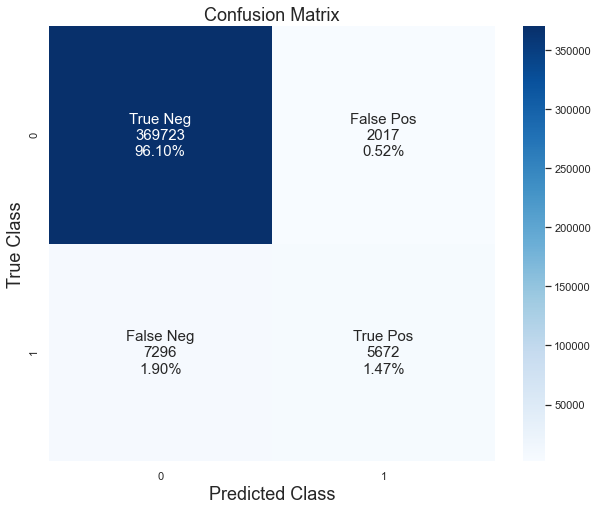

Wall time: 7min 47s


In [128]:
%%time
# Ініціалізуємо модель

XGB_model = xgb.XGBClassifier(n_estimators = CV_XGBoost.best_params_['n_estimators'],
                             objective = CV_XGBoost.best_params_['objective'],
                             random_state = CV_XGBoost.best_params_['random_state'],
                             max_depth = CV_XGBoost.best_params_['max_depth'],
                             reg_alpha = CV_XGBoost.best_params_['reg_alpha'],
                             learning_rate = CV_XGBoost.best_params_['learning_rate'],
                             n_jobs = CV_XGBoost.best_params_['n_jobs'])

# XGB_model = xgb.XGBClassifier(n_estimators = 350,
#                               learning_rate = 0.3,
#                               max_depth = 5,
#                               objective = 'binary:logistic',
#                               random_state = 42,
#                               reg_alpha = 0.01,
#                               n_jobs = -1)

# Навчаємо модель
score_XGB = XGB_model.fit(X_train, y_train)

print("************************** Train ***************************")

print ("F1 Score: %.4g" % 
       metrics.f1_score(y_train, score_XGB.predict(X_train), average='weighted'))

print ("ROC_AUC Score: %.4g" %  
       metrics.roc_auc_score(y_train, score_XGB.predict_proba(X_train)[:, 1]))

print ("Accuracy Score: %.4g" % 
       metrics.accuracy_score(y_train, score_XGB.predict(X_train)))

print("************************** Val ****************************")

print ("F1 Score: %.4g" % 
       metrics.f1_score(y_val, score_XGB.predict(X_val), average='weighted'))

print ("ROC_AUC Score: %.4g" %  
       metrics.roc_auc_score(y_val, score_XGB.predict_proba(X_val)[:, 1]))

print ("Accuracy Score: %.4g" % 
       metrics.accuracy_score(y_val, score_XGB.predict(X_val)))

print("F1 - score matrix: \n", metrics.classification_report(y_val, score_XGB.predict(X_val)))

print("Confusion matrix: \n")
#Print Confusion Matrix
cm_XGB = metrics.confusion_matrix(y_val, score_XGB.predict(X_val))

group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']

group_counts = ['{0:0.0f}'.format(value) for value in
                cm_XGB.flatten()]

group_percentages = ['{0:.2%}'.format(value) for value in
                     cm_XGB.flatten()/np.sum(cm_XGB)]

labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2,2)

plt.figure(figsize=(10,8))
sns.set_context("notebook", rc={"font.size":15,"axes.titlesize":18,"axes.labelsize":18})
sns.heatmap(cm_XGB, annot = labels, fmt='', cmap="Blues");
plt.title('Confusion Matrix')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()

************************** Test ****************************
F1 Score: 0.9726
ROC_AUC Score: 0.979
Accuracy Score: 0.9758
F1 - score matrix: 
               precision    recall  f1-score   support

           0       0.98      0.99      0.99    371741
           1       0.75      0.43      0.54     12967

    accuracy                           0.98    384708
   macro avg       0.86      0.71      0.77    384708
weighted avg       0.97      0.98      0.97    384708

Confusion matrix: 



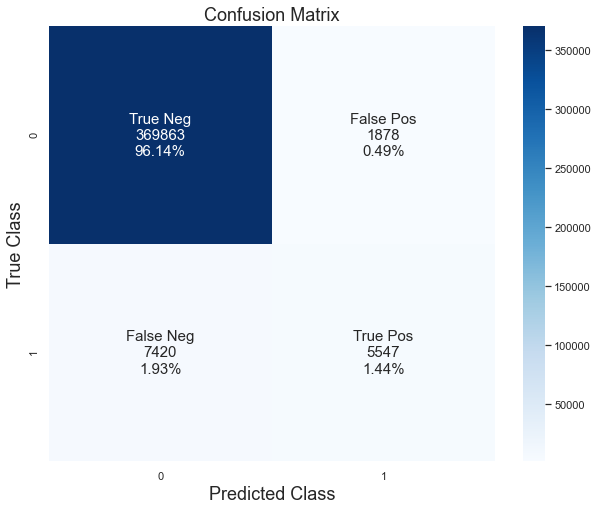

Wall time: 8.41 s


In [129]:
%%time
# Main Statistics for Test set

print("************************** Test ****************************")

print ("F1 Score: %.4g" % 
       metrics.f1_score(y_test, score_XGB.predict(X_test), average='weighted'))

print ("ROC_AUC Score: %.4g" %  
       metrics.roc_auc_score(y_test, score_XGB.predict_proba(X_test)[:, 1]))

print ("Accuracy Score: %.4g" % 
       metrics.accuracy_score(y_test, score_XGB.predict(X_test)))

print("F1 - score matrix: \n", metrics.classification_report(y_test, score_XGB.predict(X_test)))

print("Confusion matrix: \n")
#Print Confusion Matrix
cm_XGB_Test = metrics.confusion_matrix(y_test, score_XGB.predict(X_test))

group_names_Test = ['True Neg', 'False Pos', 'False Neg', 'True Pos']

group_counts_Test = ['{0:0.0f}'.format(value) for value in
                cm_XGB_Test.flatten()]

group_percentages_Test = ['{0:.2%}'.format(value) for value in
                     cm_XGB_Test.flatten()/np.sum(cm_XGB_Test)]

labels_Test = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names_Test, group_counts_Test, group_percentages_Test)]
labels_Test = np.asarray(labels_Test).reshape(2,2)

plt.figure(figsize=(10,8))
sns.set_context("notebook", rc={"font.size":15,"axes.titlesize":18,"axes.labelsize":18})
sns.heatmap(cm_XGB_Test, annot = labels_Test, fmt='', cmap="Blues");
plt.title('Confusion Matrix')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()

In [103]:
# Calculate main Results
print('******************** 1st Errors Share *********************')
Share_1st_Errors_Val =  round(
 (int(group_counts[2]) / 
 (int(group_counts[2]) + int(group_counts[3]))) * 100, 2)
print(f'Share 1st Error in Val set = { Share_1st_Errors_Val}%')

Share_1st_Errors_Test =  round(
 (int(group_counts_Test[2]) / 
 (int(group_counts_Test[2]) + int(group_counts_Test[3]))) * 100, 2)
print(f'Share 1st Error in Test set = { Share_1st_Errors_Test}%')

print('******************** Not Sent SMS Share *********************')
Share_Not_Sent_SMS_Val =  round(
 ((int(group_counts[0]) + int(group_counts[2])) / 
   sum([int(i) for i in group_counts])) * 100, 2)
print(f'Share Not Sent SMS in Val set = { Share_Not_Sent_SMS_Val}%')

Share_Not_Sent_SMS_Test =  round(
 ((int(group_counts_Test[0]) + int(group_counts_Test[2])) / 
   sum([int(i) for i in group_counts_Test])) * 100, 2)
print(f'Share Not Sent SMS in Test set = { Share_Not_Sent_SMS_Test}%')

******************** 1st Errors Share *********************
Share 1st Error in Val set = 56.26%
Share 1st Error in Test set = 57.22%
******************** Not Sent SMS Share *********************
Share Not Sent SMS in Val set = 98.0%
Share Not Sent SMS in Test set = 98.07%


###### 4.3. ТOP-features with XGBoost. 

Wall time: 125 ms


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

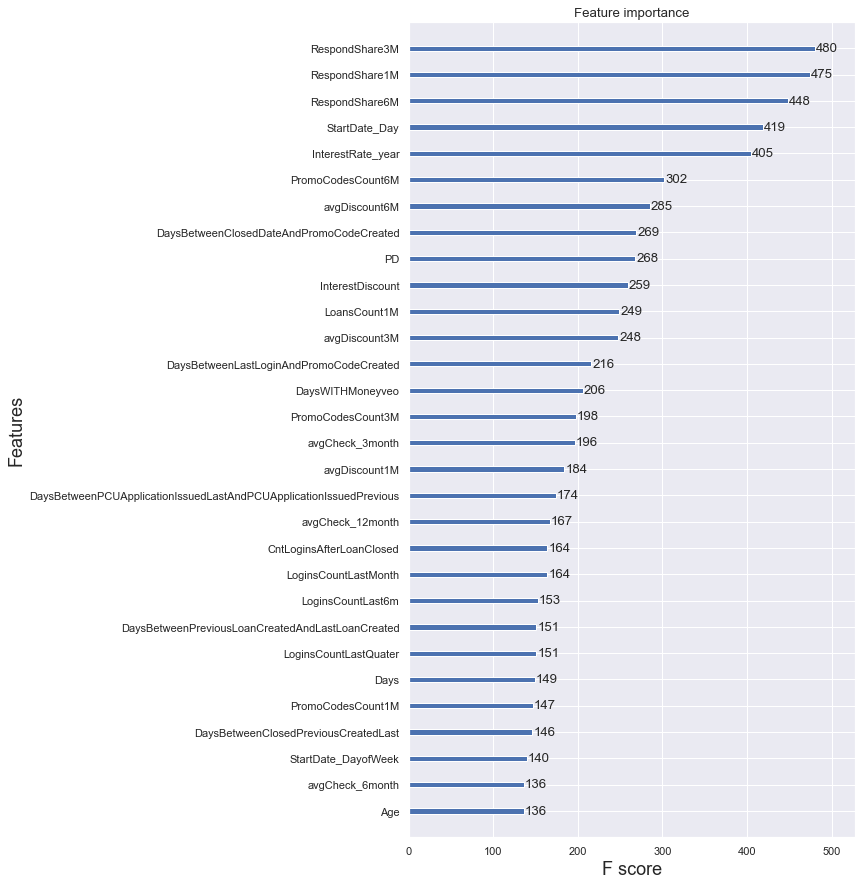

In [104]:
%%time
sns.set_style('darkgrid', {'legend.frameon':True})
fig, ax = plt.subplots(1,1,figsize=(8, 15))
sns.set(font_scale = 1.1)
sns.set_style('darkgrid', {'legend.frameon':True})
xgb.plot_importance(score_XGB, max_num_features = 30, ax = ax)

###### 4.4. Test different treshold.

In [146]:
%%time
# Predict target on Train set
Test_predict_prob = score_XGB.predict_proba(X_test)
Test_predict_prob = Test_predict_prob[:, 1]

# Explore dependencies between treshould and Business Accuracy
ShareNotSentSMS = []
ShareErrors_1 = []
TotalLostClients = []
TotalSaveClients = []
Treshould = [0.001, 0.005, 0.01, 0.02, 0.03, 0.04, 0.05,
            0.06, 0.07, 0.08, 0.09, 0.1, 0.2, 0.3, 0.4, 0.5]

for i in Treshould:
    
    # Turn probability on Test set to 0-1 binary output
    Test_predict = np.where(Test_predict_prob >= i, 1, 0)
    
    # Calculate Confusion Matrix
    cm_XGB_Treshold = metrics.confusion_matrix(y_test, Test_predict)
    group_counts_Treshold = ['{0:0.0f}'.format(value) for value in
                cm_XGB_Treshold.flatten()]
    
    ShareNotSentSMS_i =  round(
     ((int(group_counts_Treshold[0]) + int(group_counts_Treshold[2])) / 
                   (int(group_counts_Treshold[0]) + int(group_counts_Treshold[1]) + 
                    int(group_counts_Treshold[2]) + int(group_counts_Treshold[3]))) * 100, 2)
    ShareNotSentSMS.append(ShareNotSentSMS_i)
    
    ShareErrors_1_i =  round(
     (int(group_counts_Treshold[2]) / 
     (int(group_counts_Treshold[2]) + int(group_counts_Treshold[3]))) * 100, 2)
    ShareErrors_1.append(ShareErrors_1_i)

    TotalLostClients_i = group_counts_Treshold[2]
    TotalLostClients.append(TotalLostClients_i)

    TotalSaveClients_i = group_counts_Treshold[3]
    TotalSaveClients.append(TotalSaveClients_i)

Wall time: 5.36 s


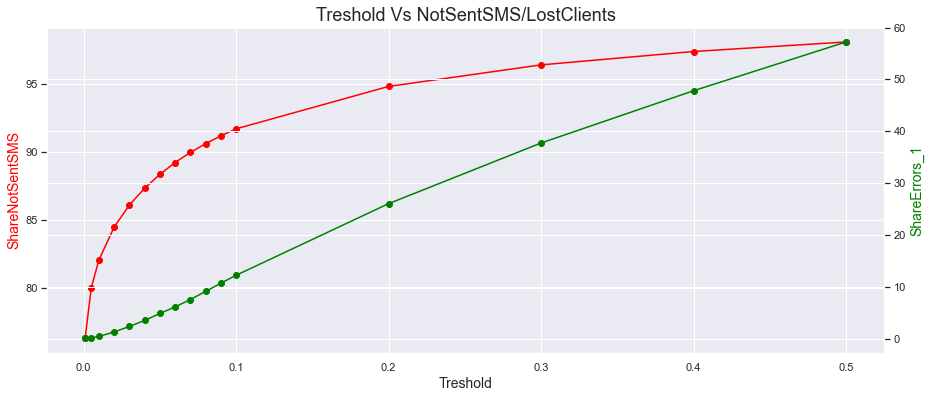

In [150]:
# create figure and axis objects with subplots()
fig, ax = plt.subplots(figsize=(15, 6))

# Make a plot
ax.plot(Treshould, ShareNotSentSMS, color = "red", marker = "o")

# Set x-axis label
ax.set_xlabel("Treshold", fontsize = 14)

# Set y-axis label
ax.set_ylabel("ShareNotSentSMS", color = "red", fontsize = 14)

# Twin object for two different y-axis on the sample plot
ax2 = ax.twinx()

# Make a plot with different y-axis using second axis object
ax2.plot(Treshould, ShareErrors_1, color = "green", marker = "o")
ax2.set_ylabel("ShareErrors_1", color = "green", fontsize = 14)

plt.title('Treshold Vs NotSentSMS/LostClients')
plt.show()
# save the plot as a file
# fig.savefig('two_different_y_axis_for_single_python_plot_with_twinx.jpg',
#             format='jpeg',
#             dpi=100,
#             bbox_inches='tight')

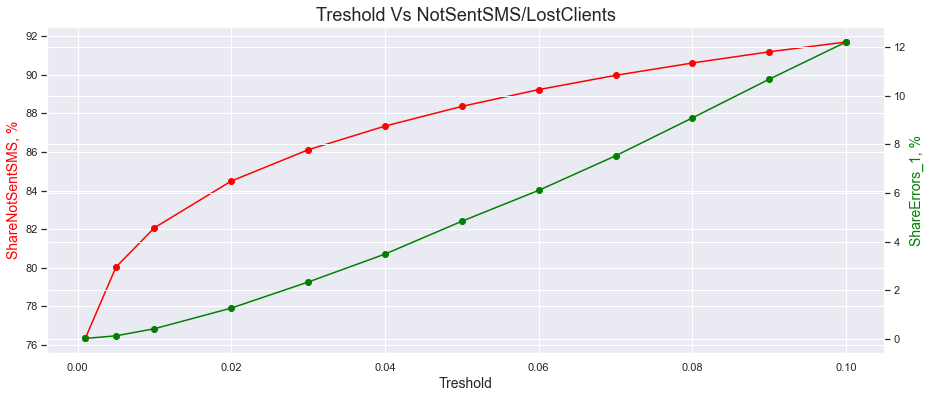

In [151]:
# create figure and axis objects with subplots()
fig, ax = plt.subplots(figsize=(15, 6))

# Make a plot
ax.plot(Treshould[:12], ShareNotSentSMS[:12], color = "red", marker = "o")

# Set x-axis label
ax.set_xlabel("Treshold", fontsize = 14)

# Set y-axis label
ax.set_ylabel("ShareNotSentSMS, %", color = "red", fontsize = 14)

# Twin object for two different y-axis on the sample plot
ax2 = ax.twinx()

# Make a plot with different y-axis using second axis object
ax2.plot(Treshould[:12], ShareErrors_1[:12], color = "green", marker = "o")
ax2.set_ylabel("ShareErrors_1, %", color = "green", fontsize = 14)

plt.title('Treshold Vs NotSentSMS/LostClients')
plt.show()
# save the plot as a file
# fig.savefig('two_different_y_axis_for_single_python_plot_with_twinx.jpg',
#             format='jpeg',
#             dpi=100,
#             bbox_inches='tight')

###### 4.5. Choose treshold = 0.01.

************************** Test ****************************
F1 Score: 0.8981
ROC_AUC Score: 0.979
Accuracy Score: 0.8542
F1 - score matrix: 
               precision    recall  f1-score   support

           0       1.00      0.85      0.92    371741
           1       0.19      1.00      0.32     12967

    accuracy                           0.85    384708
   macro avg       0.59      0.92      0.62    384708
weighted avg       0.97      0.85      0.90    384708

Confusion matrix: 



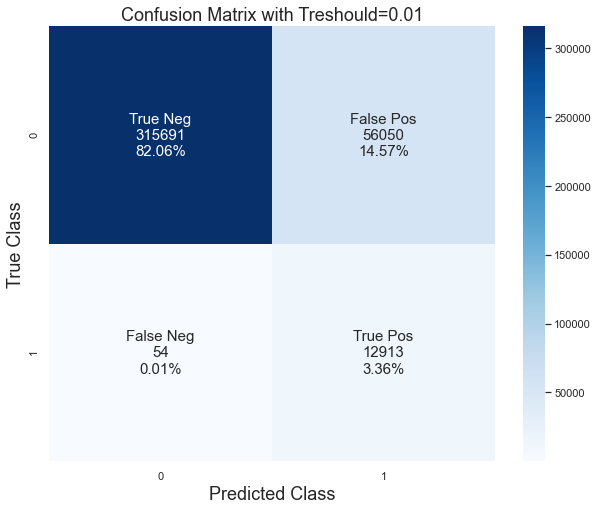

Wall time: 2.46 s


In [167]:
%%time
############################### Choose Best Treshold ################################
treshould = 0.01

#Predict on Test set
Test_predict_prob = score_XGB.predict_proba(X_test)
Test_predict_prob = Test_predict_prob[:, 1]

#Turn probability on Test set to 0-1 binary output
Test_predict = np.where(Test_predict_prob >= treshould, 1, 0)

print("************************** Test ****************************")

print("F1 Score: %.4g" % 
       metrics.f1_score(y_test, Test_predict, average='weighted'))

print("ROC_AUC Score: %.4g" %  
       metrics.roc_auc_score(y_test, Test_predict_prob))

print("Accuracy Score: %.4g" % 
       metrics.accuracy_score(y_test, Test_predict))

print("F1 - score matrix: \n", metrics.classification_report(y_test, Test_predict))

print("Confusion matrix: \n")

#Print Confusion Matrix
cm_XGB_Treshold = metrics.confusion_matrix(y_test, Test_predict)
       
group_names_Treshold = ['True Neg', 'False Pos', 'False Neg', 'True Pos']

group_counts_Treshold = ['{0:0.0f}'.format(value) for value in
                cm_XGB_Treshold.flatten()]

group_percentages_Treshold = ['{0:.2%}'.format(value) for value in
                     cm_XGB_Treshold.flatten()/np.sum(cm_XGB_Treshold)]

labels_Treshold = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names_Treshold, group_counts_Treshold, group_percentages_Treshold)]
labels_Treshold = np.asarray(labels_Treshold).reshape(2,2)

plt.figure(figsize=(10,8))
sns.set_context("notebook", rc={"font.size":15,"axes.titlesize":18,"axes.labelsize":18})
sns.heatmap(cm_XGB_Treshold, annot = labels_Treshold, fmt='', cmap="Blues");
plt.title(f'Confusion Matrix with Treshould={treshould}')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')

plt.show()

In [168]:
# Calculate main Results
print('******************** 1st Errors Share *********************')
Share_1st_Errors_Test =  round(
 (int(group_counts_Treshold[2]) / 
 (int(group_counts_Treshold[2]) + int(group_counts_Treshold[3]))) * 100, 2)
print(f'Share 1st Error in Test set = { Share_1st_Errors_Test}%')

print('******************** Not Sent SMS Share *********************')
Share_Not_Sent_SMS_Test =  round(
 ((int(group_counts_Treshold[0]) + int(group_counts_Treshold[2])) / 
   sum([int(i) for i in group_counts_Treshold])) * 100, 2)
print(f'Share Not Sent SMS in Test set = { Share_Not_Sent_SMS_Test}%')

******************** 1st Errors Share *********************
Share 1st Error in Test set = 0.42%
******************** Not Sent SMS Share *********************
Share Not Sent SMS in Test set = 82.07%


### 5. Dimensionality Reduction and Clustering.

In [152]:
# Undersampling data 
not_Apps = data_total[data_total.isCreated  == 0]
is_Apps = data_total[data_total.isCreated  == 1]

not_Apps_downsampled = resample(not_Apps,
                                replace = False, # sample without replacement
                                n_samples = len(is_Apps), # match minority n
                                random_state = 42) # reproducible results

# combine minority and downsampled majority
data_downsampled = pd.concat([not_Apps_downsampled, is_Apps])

# checking counts
data_downsampled.isCreated.value_counts()

0    64837
1    64837
Name: isCreated, dtype: int64

In [153]:
# Генеруємо категоріальні ознаки
data_downsampled_cat = data_downsampled[column_categorical]

print("Shape categorical table: ", data_downsampled_cat.shape)

Shape categorical table:  (129674, 7)


In [154]:
%%time

# We use Ordinal Encoder 
OE_downsampled = OrdinalEncoder().fit(data_downsampled_cat)
 
data_downsampled_cat_OE = OE.transform(data_downsampled_cat)

data_downsampled_cat_OE.head()

Wall time: 1.6 s


PreviousStatusGroupName  Region  MaritalStatus  Education  \
1954956                        1      19              2          2   
2236545                        1       3              2          1   
1003155                        1      19              2          3   
300633                         1       9              2          3   
852630                         1      19              2          3   

         EmploymentIndustry  EmploymentStatus  cpa  
1954956                   1                 3    1  
2236545                   2                 3    1  
1003155                   3                 3    6  
300633                    6                 3   27  
852630                    2                 3    6

In [155]:
# Merge tables:
######################################## No Scaled #####################################
data_downsampled = pd.concat([data_downsampled[column_numbers + ['isCreated']], 
                              data_downsampled_cat_OE], 
                             axis = 1)

print("############################## No Scaled tables ###############################")
print("Total Train-Test shape: ", data_downsampled.shape)

############################## No Scaled tables ###############################
Total Train-Test shape:  (129674, 70)


In [156]:
# T-SNE Implementation
t0 = time.time()
X_reduced_tsne = TSNE(n_components = 2, 
                      random_state = 42).fit_transform(data_downsampled)
t1 = time.time()
print("T-SNE took {:.2} s".format(t1 - t0))

# PCA Implementation
t0 = time.time()
X_reduced_pca = PCA(n_components = 2, 
                    random_state = 42).fit_transform(data_downsampled)
t1 = time.time()
print("PCA took {:.2} s".format(t1 - t0))

# TruncatedSVD
t0 = time.time()
X_reduced_svd = TruncatedSVD(n_components = 2, 
                             algorithm = 'randomized', 
                             random_state = 42).fit_transform(data_downsampled)
t1 = time.time()
print("Truncated SVD took {:.2} s".format(t1 - t0))

T-SNE took 6.7e+02 s
PCA took 0.52 s
Truncated SVD took 0.36 s


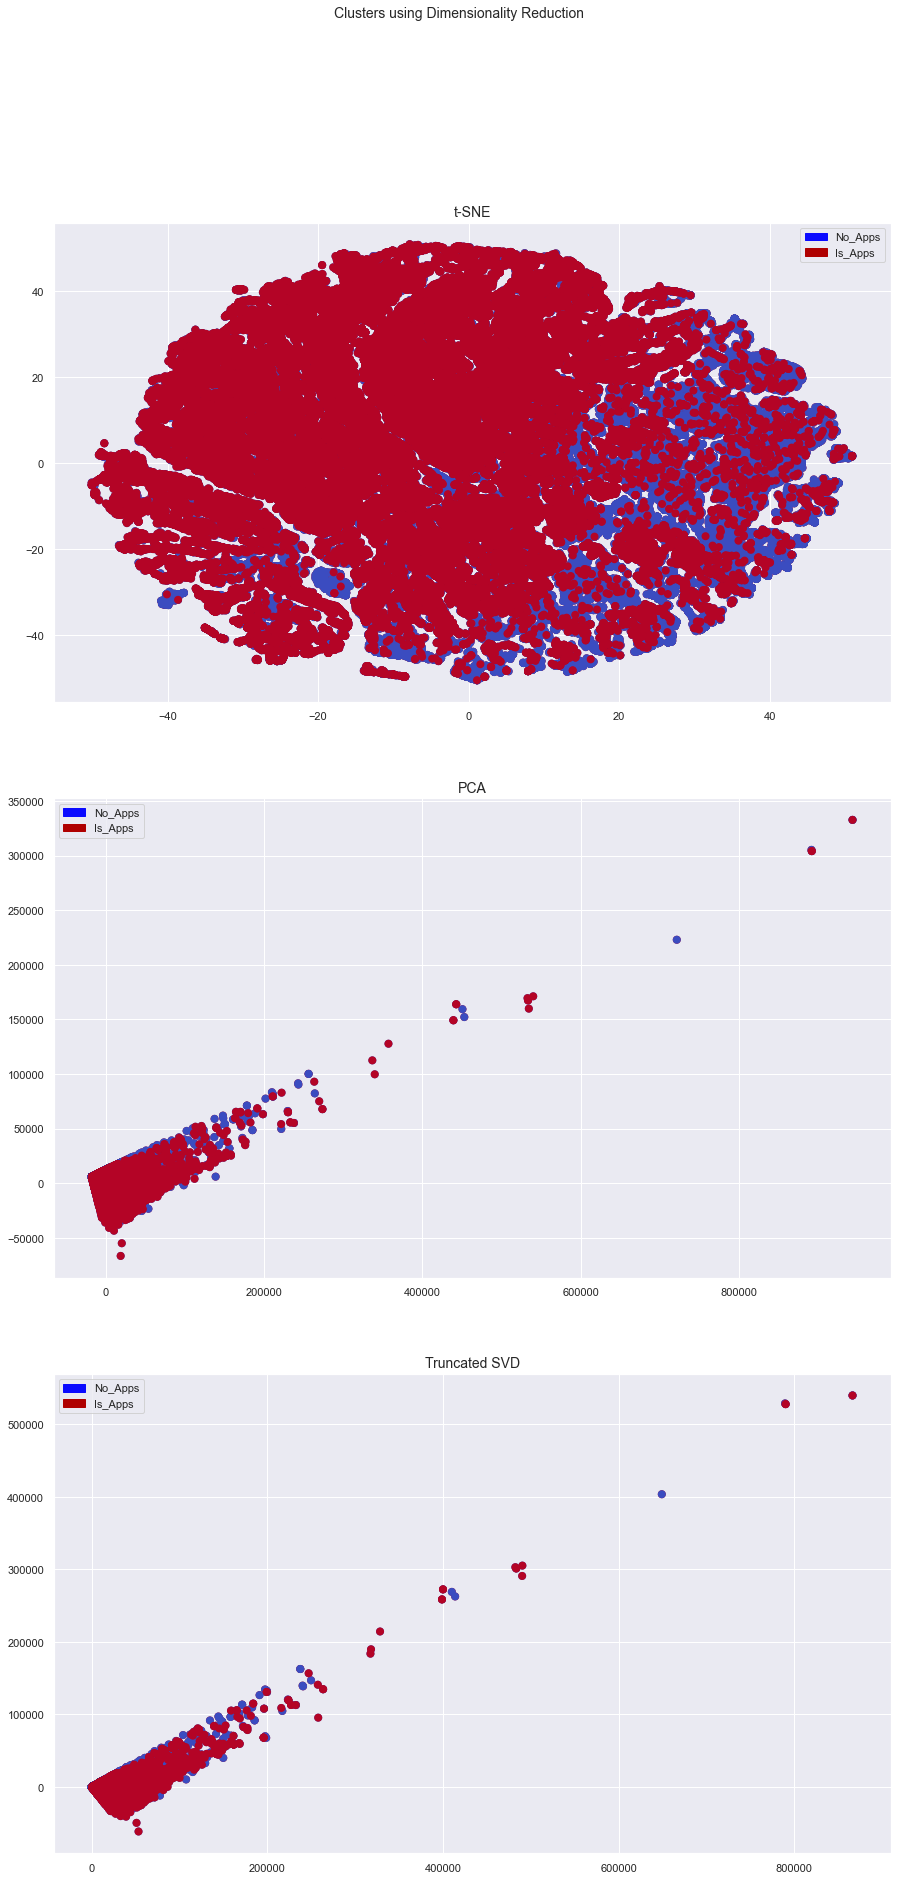

Wall time: 15.7 s


In [157]:
%%time
sns.set_context("notebook", rc={"font.size":15,"axes.titlesize":18,"axes.labelsize":18})
f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 30))
f.suptitle('Clusters using Dimensionality Reduction', fontsize=14)


blue_patch = mpatches.Patch(color='#0A0AFF', label='No_Apps')
red_patch = mpatches.Patch(color='#AF0000', label='Is_Apps')


# t-SNE scatter plot
ax1.scatter(X_reduced_tsne[:,0], 
            X_reduced_tsne[:,1], 
            c = (data_downsampled['isCreated'] == 0), 
            cmap ='coolwarm', 
            label ='No_Apps', 
            linewidths = 2)
ax1.scatter(X_reduced_tsne[:,0], 
            X_reduced_tsne[:,1], 
            c = (data_downsampled['isCreated'] == 1), 
            cmap = 'coolwarm', 
            label ='Is_Apps', 
            linewidths=2)
ax1.set_title('t-SNE', fontsize=14)

ax1.grid(True)

ax1.legend(handles=[blue_patch, red_patch])

# PCA scatter plot
ax2.scatter(X_reduced_pca[:,0], 
            X_reduced_pca[:,1], 
            c = (data_downsampled['isCreated'] == 0), 
            cmap='coolwarm', 
            label='No_Apps', 
            linewidths=2)
ax2.scatter(X_reduced_pca[:,0], 
            X_reduced_pca[:,1], 
            c = (data_downsampled['isCreated'] == 1), 
            cmap='coolwarm', 
            label='Is_Apps', 
            linewidths=2)
ax2.set_title('PCA', fontsize=14)

ax2.grid(True)

ax2.legend(handles=[blue_patch, red_patch])

# TruncatedSVD scatter plot
ax3.scatter(X_reduced_svd[:,0], 
            X_reduced_svd[:,1], 
            c = (data_downsampled['isCreated'] == 0), 
            cmap='coolwarm', 
            label='No_Apps', 
            linewidths=2)
ax3.scatter(X_reduced_svd[:,0], 
            X_reduced_svd[:,1], 
            c = (data_downsampled['isCreated'] == 1), 
            cmap ='coolwarm', 
            label = 'Is_Apps', 
            linewidths=2)
ax3.set_title('Truncated SVD', fontsize=14)

ax3.grid(True)

ax3.legend(handles=[blue_patch, red_patch])

plt.show()

### 6. Retrain the model on the entire dataset.

************************** Train ***************************
F1 Score: 0.9773
ROC_AUC Score: 0.9865
Accuracy Score: 0.9798
Confusion matrix: 



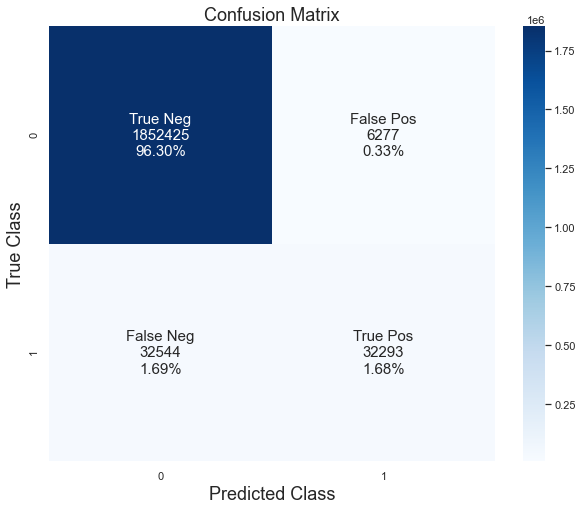

Wall time: 13min 24s


In [187]:
%%time

data_target = data_total['isCreated'].values

# Ініціалізуємо модель
XGB_model_Total = xgb.XGBClassifier(n_estimators = CV_XGBoost.best_params_['n_estimators'],
                             objective = CV_XGBoost.best_params_['objective'],
                             random_state = CV_XGBoost.best_params_['random_state'],
                             max_depth = CV_XGBoost.best_params_['max_depth'],
                             reg_alpha = CV_XGBoost.best_params_['reg_alpha'],
                             learning_rate = CV_XGBoost.best_params_['learning_rate'],
                             n_jobs = CV_XGBoost.best_params_['n_jobs'])

# XGB_model_Total = xgb.XGBClassifier(n_estimators = 250,
#                               learning_rate = 0.3,
#                               max_depth = 4,
#                               objective = 'binary:logistic',
#                               random_state = 42,
#                               reg_alpha = 0.01,
#                               n_jobs = 16)

# Навчаємо модель
score_XGB_Total = XGB_model_Total.fit(data_train, data_target)

print("************************** Train ***************************")

print ("F1 Score: %.4g" % 
       metrics.f1_score(data_target, score_XGB_Total.predict(data_train), average='weighted'))

print ("ROC_AUC Score: %.4g" %  
       metrics.roc_auc_score(data_target, score_XGB_Total.predict_proba(data_train)[:, 1]))

print ("Accuracy Score: %.4g" % 
       metrics.accuracy_score(data_target, score_XGB_Total.predict(data_train)))

print("Confusion matrix: \n")
#Print Confusion Matrix
cm_XGB_Total = metrics.confusion_matrix(data_target, score_XGB_Total.predict(data_train))

group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']

group_counts = ['{0:0.0f}'.format(value) for value in
                cm_XGB_Total.flatten()]

group_percentages = ['{0:.2%}'.format(value) for value in
                     cm_XGB_Total.flatten()/np.sum(cm_XGB_Total)]

labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2,2)

plt.figure(figsize=(10,8))
sns.set_context("notebook", rc={"font.size":15,"axes.titlesize":18,"axes.labelsize":18})
sns.heatmap(cm_XGB_Total, annot = labels, fmt='', cmap="Blues");
plt.title('Confusion Matrix')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()

************************** Total ****************************
F1 Score: 0.8985
ROC_AUC Score: 0.9846
Accuracy Score: 0.8549
F1 - score matrix: 
               precision    recall  f1-score   support

           0       1.00      0.85      0.92   1858702
           1       0.19      1.00      0.32     64837

    accuracy                           0.85   1923539
   macro avg       0.59      0.92      0.62   1923539
weighted avg       0.97      0.85      0.90   1923539

Confusion matrix: 



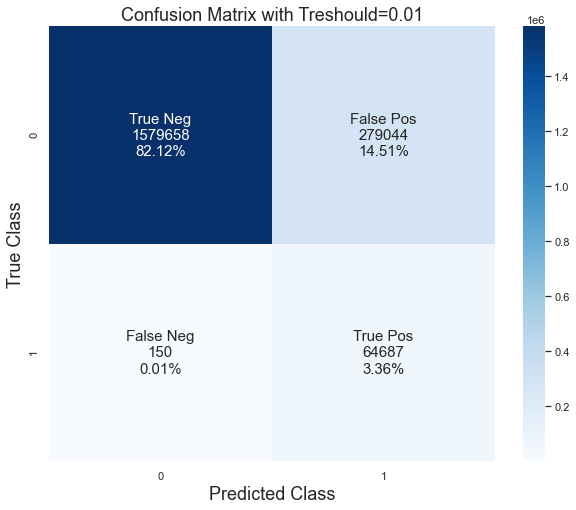

Wall time: 11.2 s


In [185]:
%%time
############################### Choose Best Treshold ################################
treshould = 0.01

#Predict on Test set
Total_predict_prob = score_XGB.predict_proba(data_train)
Total_predict_prob = Total_predict_prob[:, 1]

#Turn probability on Test set to 0-1 binary output
Total_predict = np.where(Total_predict_prob >= treshould, 1, 0)

print("************************** Total ****************************")

print("F1 Score: %.4g" % 
       metrics.f1_score(data_target, Total_predict, average='weighted'))

print("ROC_AUC Score: %.4g" %  
       metrics.roc_auc_score(data_target, Total_predict_prob))

print("Accuracy Score: %.4g" % 
       metrics.accuracy_score(data_target, Total_predict))

print("F1 - score matrix: \n", metrics.classification_report(data_target, Total_predict))

print("Confusion matrix: \n")

#Print Confusion Matrix
cm_XGB_Treshold_Total = metrics.confusion_matrix(data_target, Total_predict)
       
group_names_Treshold_Total = ['True Neg', 'False Pos', 'False Neg', 'True Pos']

group_counts_Treshold_Total = ['{0:0.0f}'.format(value) for value in
                cm_XGB_Treshold_Total.flatten()]

group_percentages_Treshold_Total = ['{0:.2%}'.format(value) for value in
                     cm_XGB_Treshold_Total.flatten()/np.sum(cm_XGB_Treshold_Total)]

labels_Treshold_Total = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names_Treshold_Total, group_counts_Treshold_Total, group_percentages_Treshold_Total)]
labels_Treshold_Total = np.asarray(labels_Treshold_Total).reshape(2,2)

plt.figure(figsize=(10,8))
sns.set_context("notebook", rc={"font.size":15,"axes.titlesize":18,"axes.labelsize":18})
sns.heatmap(cm_XGB_Treshold_Total, annot = labels_Treshold_Total, fmt='', cmap="Blues");
plt.title(f'Confusion Matrix with Treshould={treshould}')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')

plt.show()

In [186]:
# Calculate main Results
print('******************** 1st Errors Share *********************')
Share_1st_Errors_Total=  round(
 (int(group_counts_Treshold_Total[2]) / 
 (int(group_counts_Treshold_Total[2]) + int(group_counts_Treshold_Total[3]))) * 100, 2)
print(f'Share 1st Error in Test set = { Share_1st_Errors_Total}%')

print('******************** Not Sent SMS Share *********************')
Share_Not_Sent_SMS_Total =  round(
 ((int(group_counts_Treshold_Total[0]) + int(group_counts_Treshold_Total[2])) / 
   sum([int(i) for i in group_counts_Treshold_Total])) * 100, 2)
print(f'Share Not Sent SMS in Test set = { Share_Not_Sent_SMS_Total}%')

******************** 1st Errors Share *********************
Share 1st Error in Test set = 0.23%
******************** Not Sent SMS Share *********************
Share Not Sent SMS in Test set = 82.13%


### 7. Save model.

In [111]:
# Active path
path = os.chdir('C:\\Users\\Andrei.Konograi\\Promo Score\\Save_Models')
print("Working directory is:", os.getcwd())

# Save model
pickle.dump(score_XGB_Total, open("XGB_PromoScore_model_Total.pkl", "wb"))

Working directory is: C:\Users\Andrei.Konograi\Promo Score\Save_Models
